![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from French to English.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](http://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a single vector, and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

# Sequence to Sequence Learning

A [Sequence to Sequence network](http://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![](https://i.imgur.com/tVtHhNp.png)

When using a single RNN, there is a one-to-one relationship between inputs and outputs. We would quickly run into problems with different sequence orders and lengths that are common during translation. Consider the simple sentence "Je ne suis pas le chat noir" &rarr; "I am not the black cat". Many of the words have a pretty direct translation, like "chat" &rarr; "cat". However the differing grammars cause words to be in different orders, e.g. "chat noir" and "black cat". There is also the "ne ... pas" &rarr; "not" construction that makes the two sentences have different lengths.

With the seq2seq model, by encoding many inputs into one vector, and decoding from one vector into many outputs, we are freed from the constraints of sequence order and length. The encoded sequence is represented by a single vector, a single point in some N dimensional space of sequences. In an ideal case, this point can be considered the "meaning" of the sequence.

This idea can be extended beyond sequences. Image captioning tasks take an [image as input, and output a description](https://arxiv.org/abs/1411.4555) of the image (img2seq). Some image generation tasks take a [description as input and output a generated image](https://arxiv.org/abs/1511.02793) (seq2img). These models can be referred to more generally as "encoder decoder" networks.

## The Attention Mechanism

The fixed-length vector carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

The **attention mechanism** [introduced by Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![](https://i.imgur.com/5y6SCvU.png)

Attention is calculated using the current hidden state and each encoder output, resulting in a vector the same size as the input sequence, called the *attention weights*. These weights are multiplied by the encoder outputs to create a weighted sum of encoder outputs, which is called the *context* vector. The context vector and hidden state are used to predict the next output element.

![](https://i.imgur.com/K1qMPxs.png)

# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later. The rest are builtin Python libraries.

In [1]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
# %matplotlib inline

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [2]:
USE_CUDA = True

## Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site http://tatoeba.org/ which has downloads available at http://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download `fra-eng.zip`, extract the text file in there, and rename it to `data/eng-fra.txt` before continuing (for some reason the zipfile is named backwards). The file is a tab separated list of translation pairs:

```
I am cold.    Je suis froid.
```

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word (`word2count`). This class includes a function `trim(min_count)` to remove rare words once they are all counted.

In [3]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

        for word in keep_words:
            self.index_word(word)

### Reading and decoding files

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
# def unicode_to_ascii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#     )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
#     s = unicode_to_ascii(s.lower().strip())
    s = s.lower().strip()
    s = re.sub(r"([,.!?])", r" \1 ", s)
#     s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s
  
normalize_string('ala ma kota ąćęłńóśźż ĄĆĘŁŃÓŚŹŻ')

'ala ma kota ąćęłńóśźż ąćęłńóśźż'

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English &rarr; Other Language, so if we want to translate from Other Language &rarr; English I added the `reverse` flag to reverse the pairs.

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
#     filename = '../data/%s-%s.txt' % (lang1, lang2)
    filename = 'data/seq2seq/%s-%s.txt' % (lang1, lang2)
    lines = open(filename).read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
# MIN_LENGTH = 3
# MAX_LENGTH = 25
MIN_LENGTH = 1
MAX_LENGTH = 100


def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

The full process for preparing the data is:

* Read text file and split into lines
* Split lines into pairs and normalize
* Filter to pairs of a certain length
* Make word lists from sentences in pairs

In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %d sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])
    
    print('Indexed %d words in input language, %d words in output' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'pol', False)

Reading lines...
Read 36856 sentence pairs
Filtered to 36756 pairs
Indexing words...
Indexed 8235 words in input language, 20176 words in output


### Filtering vocabularies

To get something that trains in under an hour, we'll trim the data set a bit. First we will use the `trim` function on each language (defined above) to only include words that are repeated a certain amount of times through the dataset (this softens the difficulty of learning a correct translation for words that don't appear often).

In [8]:
MIN_COUNT = 2  # 3 # 5

input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)

keep_words 4969 / 8232 = 0.6036
keep_words 9574 / 20173 = 0.4746


### Filtering pairs

Now we will go back to the set of all sentence pairs and remove those with unknown words.

In [9]:
keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    
    for word in input_sentence.split(' '):
        if word not in input_lang.word2index:
            keep_input = False
            break

    for word in output_sentence.split(' '):
        if word not in output_lang.word2index:
            keep_output = False
            break

    # Remove if pair doesn't match input and output conditions
    if keep_input and keep_output:
        keep_pairs.append(pair)

print("Trimmed from %d pairs to %d, %.4f of total" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs

Trimmed from 36756 pairs to 27450, 0.7468 of total


## Turning training data into Tensors

To train we need to turn the sentences into something the neural network can understand, which of course means numbers. Each sentence will be split into words and turned into a `LongTensor` which represents the index (from the Lang indexes made earlier) of each word. While creating these tensors we will also append the EOS token to signal that the sentence is over.

![](https://i.imgur.com/LzocpGH.png)

In [10]:
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

We can make better use of the GPU by training on batches of many sequences at once, but doing so brings up the question of how to deal with sequences of varying lengths. The simple solution is to "pad" the shorter sentences with some padding symbol (in this case `0`), and ignore these padded spots when calculating the loss.

![](https://i.imgur.com/gGlkEEF.png)

In [11]:
# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

To create a Variable for a full batch of inputs (and targets) we get a random sample of sequences and pad them all to the length of the longest sequence. We'll keep track of the lengths of each batch in order to un-pad later.

Initializing a `LongTensor` with an array (batches) of arrays (sequences) gives us a `(batch_size x max_len)` tensor - selecting the first dimension gives you a single batch, which is a full sequence. When training the model we'll want a single time step at once, so we'll transpose to `(max_len x batch_size)`. Now selecting along the first dimension returns a single time step across batches.

![](https://i.imgur.com/nBxTG3v.png)

In [12]:
def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(input_lang, pair[0]))
        target_seqs.append(indexes_from_sentence(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

We can test this to see that it will return a `(max_len x batch_size)` tensor for input and target sentences, along with a corresponding list of batch lenghts for each (which we will use for masking later).

In [13]:
random_batch(2)

(tensor([[  477,    42],
         [   30,   569],
         [ 1613,    15],
         [  194,   543],
         [ 1679,     4],
         [    4,     2],
         [    2,     0]], device='cuda:0'), [7, 6], tensor([[  628,  1036],
         [   41,    22],
         [ 2392,  1567],
         [  127,     4],
         [ 2512,     2],
         [    4,     0],
         [    2,     0]], device='cuda:0'), [7, 5])

# Building the models

## The Encoder

<img src="https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/images/encoder-network.png?raw=true" style="float: right" />

The encoder will take a batch of word sequences, a `LongTensor` of size `(max_len x batch_size)`, and output an encoding for each word, a `FloatTensor` of size `(max_len x batch_size x hidden_size)`.

The word inputs are fed through an [embedding layer `nn.Embedding`](http://pytorch.org/docs/nn.html#embedding) to create an embedding for each word, with size `seq_len x hidden_size` (as if it was a batch of words). This is resized to `seq_len x 1 x hidden_size` to fit the expected input of the [GRU layer `nn.GRU`](http://pytorch.org/docs/nn.html#gru). The GRU will return both an output sequence of size `seq_len x hidden_size`.

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

## Attention Decoder

### Interpreting the Bahdanau et al. model

[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) (Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio) introduced the idea of using attention for seq2seq translation.

Each decoder output is conditioned on the previous outputs and some $\mathbf x$, where $\mathbf x$ consists of the current hidden state (which takes into account previous outputs) and the attention "context", which is calculated below. The function $g$ is a fully-connected layer with a nonlinear activation, which takes as input the values $y_{i-1}$, $s_i$, and $c_i$ concatenated.

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

The current hidden state $s_i$ is calculated by an RNN $f$ with the last hidden state $s_{i-1}$, last decoder output value $y_{i-1}$, and context vector $c_i$.

In the code, the RNN will be a `nn.GRU` layer, the hidden state $s_i$ will be called `hidden`, the output $y_i$ called `output`, and context $c_i$ called `context`.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

The context vector $c_i$ is a weighted sum of all encoder outputs, where each weight $a_{ij}$ is the amount of "attention" paid to the corresponding encoder output $h_j$.

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... where each weight $a_{ij}$ is a normalized (over all steps) attention "energy" $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... where each attention energy is calculated with some function $a$ (such as another linear layer) using the last hidden state $s_{i-1}$ and that particular encoder output $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Interpreting the Luong et al. models

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) (Minh-Thang Luong, Hieu Pham, Christopher D. Manning) describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

The specific "score" function that compares two states is either *dot*, a simple dot product between the states; *general*, a a dot product between the decoder hidden state and a linear transform of the encoder state; or *concat*, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

### Implementing an attention module

In [15]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        # return F.softmax(attn_energies).unsqueeze(1)
        return F.softmax(attn_energies, dim=-1).unsqueeze(1)
    
#     def score(self, hidden, encoder_output):
        
#         if self.method == 'dot':
#             energy = hidden.dot(encoder_output)
#             return energy
        
#         elif self.method == 'general':
#             energy = self.attn(encoder_output)
#             energy = hidden.dot(energy)
#             return energy
        
#         elif self.method == 'concat':
#             energy = self.attn(torch.cat((hidden, encoder_output), 1))
#             energy = self.v.dot(energy)
#             return energy

    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

### Implementing the Bahdanau et al. model

In summary our decoder should consist of four main parts - an embedding layer turning an input word into a vector; a layer to calculate the attention energy per encoder output; a RNN layer; and an output layer.

The decoder's inputs are the last RNN hidden state $s_{i-1}$, last output $y_{i-1}$, and all encoder outputs $h_*$.

* embedding layer with inputs $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* attention layer $a$ with inputs $(s_{i-1}, h_j)$ and outputs $e_{ij}$, normalized to create $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* context vector $c_i$ as an attention-weighted average of encoder outputs
    * `context = sum(attn_weights * encoder_outputs)`
* RNN layer(s) $f$ with inputs $(s_{i-1}, y_{i-1}, c_i)$ and internal hidden state, outputting $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* an output layer $g$ with inputs $(y_{i-1}, s_i, c_i)$, outputting $y_i$
    * `output = out(embedded, rnn_output, context)`

In [16]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        # output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        output = F.log_softmax(self.out(torch.cat((output, context), 1)), dim=-1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

Now we can build a decoder that plugs this Attn module in after the RNN to calculate attention weights, and apply those weights to the encoder outputs to get a context vector.

In [17]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

## Testing the models

To make sure the encoder and decoder modules are working (and working together) we'll do a full test with a small batch.

In [18]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([10, 3])
target_batches torch.Size([8, 3])


Create models with a small size (a good idea for eyeball inspection):

In [19]:
small_hidden_size = 8
small_n_layers = 2

encoder_test = EncoderRNN(input_lang.n_words, small_hidden_size, small_n_layers)
decoder_test = LuongAttnDecoderRNN('general', small_hidden_size, output_lang.n_words, small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

To test the encoder, run the input batch through to get per-batch encoder outputs:

In [20]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([10, 3, 8])
encoder_hidden torch.Size([4, 3, 8])


Then starting with a SOS token, run word tokens through the decoder to get each next word token. Instead of doing this with the whole sequence, it is done one at a time, to support using it's own predictions to make the next prediction. This will be one time step at a time, but batched per time step. In order to get this to work for short padded sequences, the batch size is going to get smaller each time.

In [21]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths
)
# print('loss', loss.data[0])
print('loss', loss.item())

loss 9.171732902526855


# Training

## Defining a training iteration

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

### Teacher Forcing vs. Scheduled Sampling

"Teacher Forcing", or maximum likelihood sampling, means using the real target outputs as each next input when training. The alternative is using the decoder's own guess as the next input. Using teacher forcing may cause the network to converge faster, but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - you could think of it as having learned how to listen to the teacher's instructions, without learning how to venture out on its own.

The solution to the teacher-forcing "problem" is known as [Scheduled Sampling](https://arxiv.org/abs/1506.03099), which simply alternates between using the target values and predicted values when training. We will randomly choose to use teacher forcing with an if statement while training - sometimes we'll feed use real target as the input (ignoring the decoder's output), sometimes we'll use the decoder's output.

In [22]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
#     ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
#     dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
#     return loss.data[0], ec, dc
    return loss.item(), ec, dc  

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, a loss function (criterion), and set up variables for plotting and tracking progress:

In [23]:
# Configure models
attn_model = 'dot'
hidden_size = 500
n_layers = 2
dropout = 0.1
batch_size = 50 # 1600  # 100
# batch_size = 50

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 50000 # 50000
epoch = 0
plot_every = 10
print_every = 50  # 100
evaluate_every = 50 # 1000

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

In [24]:
from torchnet.logger import VisdomPlotLogger, VisdomLogger, VisdomTextLogger
from tqdm import tqdm
import io
import json

# Start a job

class Job:
    def __init__(self, name, params={}, hostname='localhost', port=8890, n_epochs=10):
        self.name = name
        self.params = params
        self.hostname = hostname
        self.port = port
        self.avg_train_loss_logger = VisdomPlotLogger(
        'line', port=port, opts={'title': f'{name}_Train Loss'})
        self.job_logger = VisdomTextLogger(port=port, opts={'title': f'{name}_Job Info'})
        self.log_logger = VisdomTextLogger(port=port, opts={'title': f'{name}_Train Loss Log'}, update_type='APPEND')
        self.pbar = tqdm(total=n_epochs, ncols=60, mininterval=1.0, ascii=True, file=io.StringIO())
        self.progress_logger = VisdomTextLogger(port=port, opts=dict(title=f'{name}_Progress Bar',
            width=500,
            height=50,
        ))

        self.start()

    def start(self):
#         j = {'name': self.name, 'params': self.params, 'hostname': self.hostname}
        j_str = json.dumps(self.params, indent=4)
        j_str = j_str.replace('\n', '<br/>\n').replace(' ', '&nbsp;')
        self.job_logger.log(f'{j_str}')

        self.job_id = '#job_id'# body['id']
        print("Starting job %s at %s" % (self.job_id, time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())))
        self.start_time = time.time()

        self.log_every = 50
        self.plot_every = 50
        self.loss_avg = 0

    def stop(self, ):
        j = {'status': 'done'}
        print(j)

    def log(self, l):
        def time_since(since):
            now = time.time()
            s = now - since
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)
        # print('[log] %s' % time_since(self.start_time), l)
        self.log_logger.log(l)

    def plot(self, x, y):
        # print(f'[plot] ({x}, {y})')
        self.avg_train_loss_logger.log(x, y)

    def record(self, e, loss):
        self.loss_avg += loss

        if e > 0 and e % self.log_every == 0:
            self.log('(%s) %.4f' % (e, loss))

        if e > 0 and e % self.plot_every == 0:
            self.plot(e, self.loss_avg / self.plot_every)
            self.loss_avg = 0

    def update_progress(self, ):
        self.pbar.update(1)
        text = f'{self.pbar}'.replace(' ', '<font color="white">#</font>')
        self.progress_logger.log(text)

In [25]:
# import sconce
# job = sconce.Job('seq2seq-translate', {
job = Job('seq2seq-translate', {
    'attn_model': attn_model,
    'n_layers': n_layers,
    'dropout': dropout,
    'hidden_size': hidden_size,
    'learning_rate': learning_rate,
    'clip': clip,
    'teacher_forcing_ratio': teacher_forcing_ratio,
    'decoder_learning_ratio': decoder_learning_ratio,
}, n_epochs=n_epochs)
job.plot_every = plot_every
job.log_every = print_every

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

import visdom

vis = visdom.Visdom(port=job.port)

Starting job #job_id at 2018-05-08 22:07:31


In [26]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [27]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    # https://github.com/spro/practical-pytorch/issues/95
    # input_lengths = [len(input_seq)]
    
    # UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
    # https://discuss.pytorch.org/t/torch-no-grad/12296
    
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_lengths = [len(input_seqs[0])]

    # input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1)

    if USE_CUDA:
        input_batches = input_batches.cuda()

    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)

    # Run through encoder
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    # decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)

    # Run through decoder
    for di in range(max_length):
        with torch.no_grad():
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])

        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [28]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

In [29]:
import io
import torchvision
from PIL import Image

For a better viewing experience we will do the extra work of adding axes and labels:

In [30]:
def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

In [31]:
def show_attention(input_sentence, output_words, attentions):
    mpl.style.use('default')
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)    
    cax = ax.matshow(attentions.numpy(), cmap='jet') # cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

In [32]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
    vis.text(text, win=win, opts={'title': win})

# Putting it all together

**TODO** Run `train_epochs` for `n_epochs`

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you're running this notebook you can **train, interrupt, evaluate, and come back to continue training**. Simply run the notebook starting from the following cell (running from the previous cell will reset the models).

  0%|                 | 50/50000 [03:24<45:10:38,  3.26s/it]
3m 24s (- 3396m 50s) (50 0%) 6.0610
> i have a special reason .
= mam szczególny powód .
< nie nie , , , . <EOS>


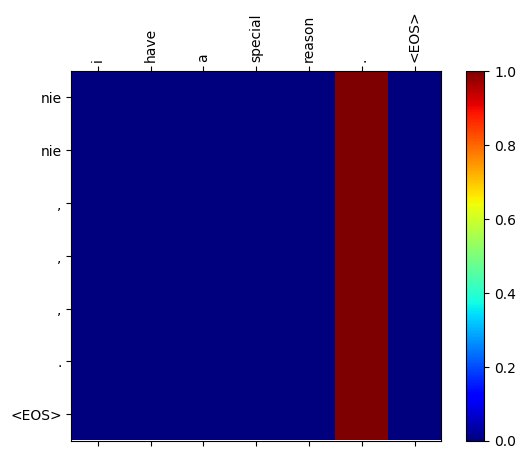

  0%|                | 100/50000 [06:23<48:04:38,  3.47s/it]
6m 23s (- 3187m 20s) (100 0%) 5.1159
> tom has a scar on his face .
= tom ma bliznę na twarzy .
< tom nie jest , że że że że jest , że że że że jest , że że że że jest , że że że że że jest . <EOS>


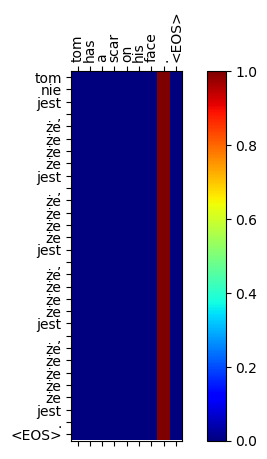

  0%|                | 150/50000 [09:23<53:33:59,  3.87s/it]
9m 23s (- 3122m 47s) (150 0%) 4.8016
> this soup is really good .
= ta zupa jest naprawdę dobra .
< to jest jest . <EOS>


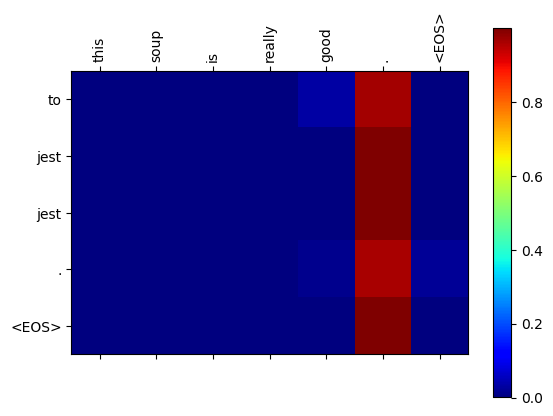

  0%|                | 200/50000 [12:26<60:36:21,  4.38s/it]
12m 26s (- 3098m 23s) (200 0%) 4.5953
> i can't remember his name .
= nie pamiętam jego imienia .
< nie mogę się . <EOS>


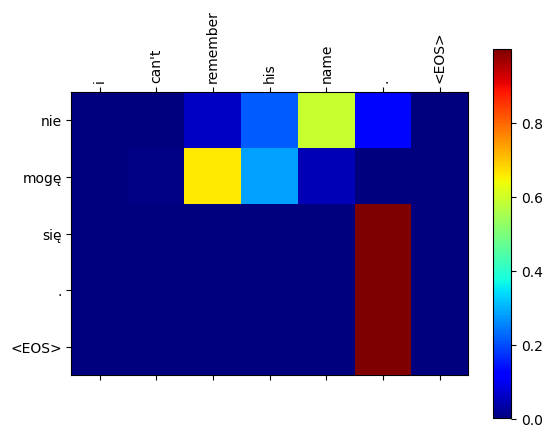

  0%|                | 250/50000 [15:16<44:19:28,  3.21s/it]
15m 16s (- 3039m 32s) (250 0%) 4.3322
> i told tom i'd help .
= powiedziałem tomowi , że pomogę .
< mam , że tom ma . <EOS>


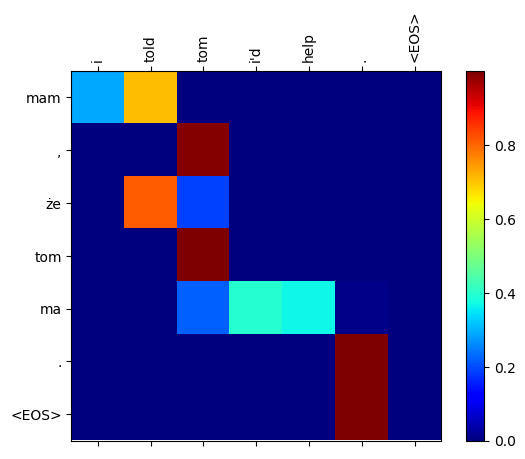

  1%|                | 300/50000 [18:05<49:25:07,  3.58s/it]
18m 5s (- 2997m 28s) (300 0%) 4.1335
> how are you ? did you have a good trip ?
= jak się masz ? miałeś dobrą podróż ?
< jak chcesz się ? <EOS>


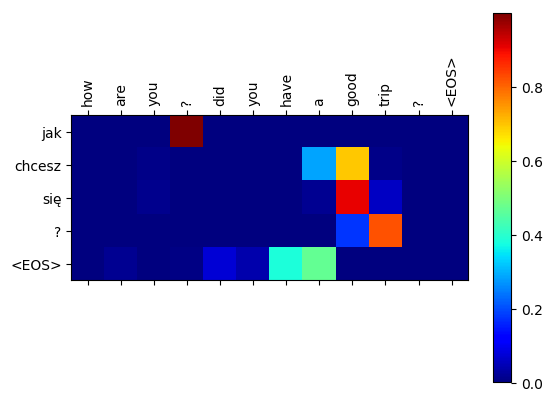

  1%|1               | 350/50000 [20:57<48:20:57,  3.51s/it]
20m 57s (- 2973m 35s) (350 0%) 4.0000
> i don't believe this is true .
= nie wierzę , że to prawda .
< nie mogę to , że to jest . <EOS>


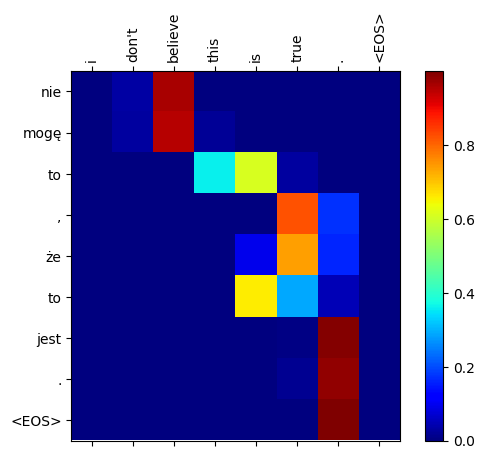

  1%|1               | 400/50000 [23:47<44:12:18,  3.21s/it]
23m 47s (- 2950m 28s) (400 0%) 3.7838
> please move this stone from here to there .
= proszę przesuń ten kamień stąd tam .
< proszę , że tu jest tu tu . <EOS>


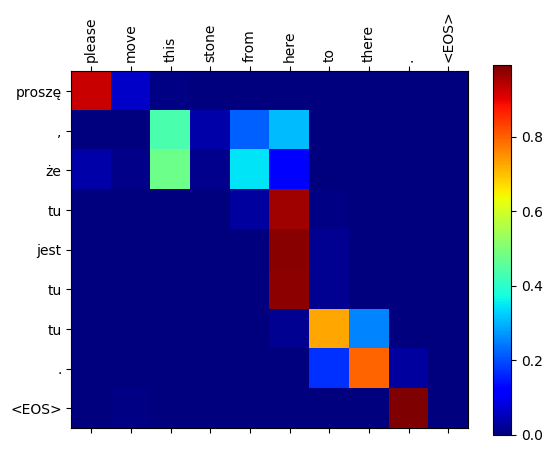

  1%|1               | 450/50000 [26:36<37:44:18,  2.74s/it]
26m 36s (- 2929m 31s) (450 0%) 3.6700
> i forgot to put sugar in your tea .
= zapomniałem dać cukru do twojej herbaty .
< chciałbym , że mogę w bostonie . <EOS>


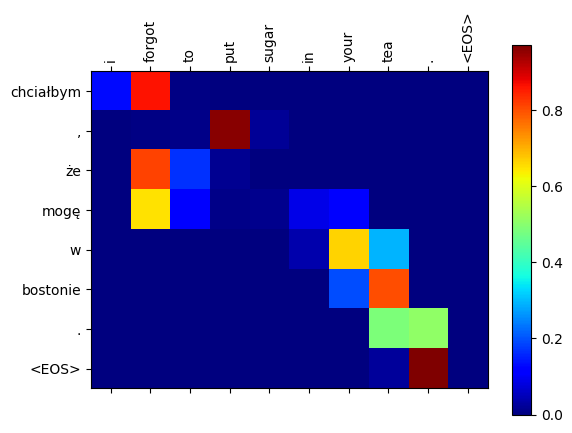

  1%|1               | 500/50000 [29:18<44:59:21,  3.27s/it]
29m 18s (- 2900m 59s) (500 1%) 3.4965
> i want to know where you were last night .
= chcę wiedzieć , gdzie byłeś zeszłej nocy .
< chcę , że jesteś , że jesteś w bostonie . <EOS>


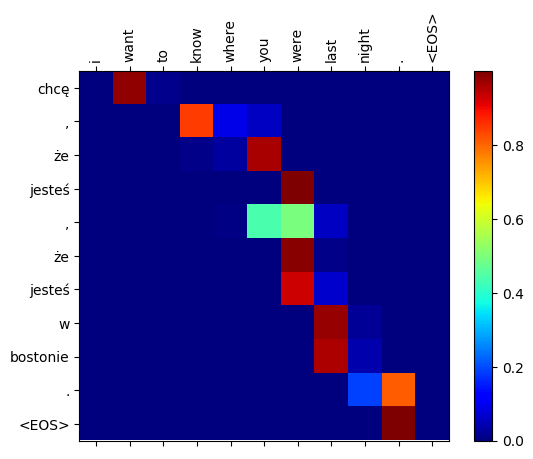

  1%|1               | 550/50000 [32:20<47:13:33,  3.44s/it]
32m 20s (- 2908m 23s) (550 1%) 3.3640
> this is my daughter .
= oto moja córka .
< to jest mój książka . <EOS>


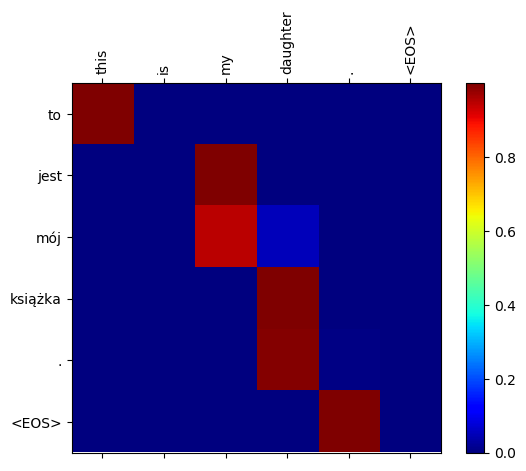

  1%|1               | 600/50000 [35:23<59:37:01,  4.34s/it]
35m 23s (- 2914m 33s) (600 1%) 3.2568
> tom is too old to do that .
= tom jest zbyt stary , żeby to zrobić .
< tom jest zbyt zbyt zrobić , co to zrobić . <EOS>


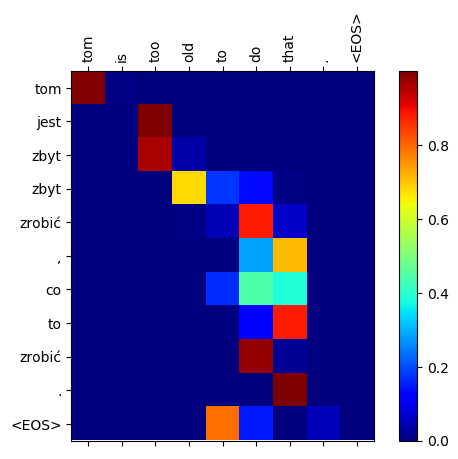

  1%|2               | 650/50000 [38:09<46:30:49,  3.39s/it]
38m 9s (- 2896m 48s) (650 1%) 3.1193
> it wasn't as helpful as i thought it would be .
= to nie było aż tak pomocne , jak się spodziewałem .
< nie tak tak , że to powiedziałem . <EOS>


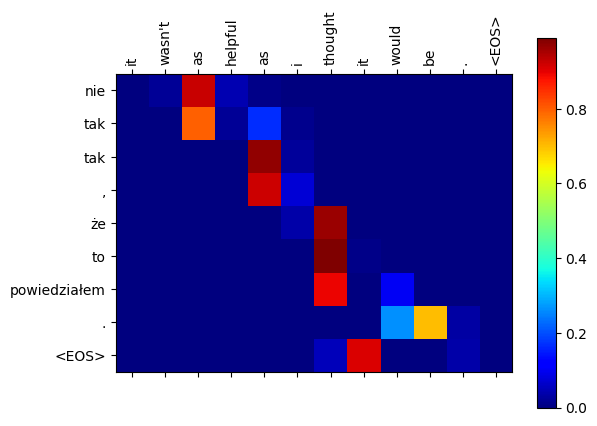

  1%|2               | 700/50000 [40:59<44:12:43,  3.23s/it]
40m 59s (- 2887m 16s) (700 1%) 2.9895
> he showed me the manuscript of his new play .
= pokazał mi rękopis swojej nowej sztuki .
< on mi mi się z swojej własnego i jego pokoju . <EOS>


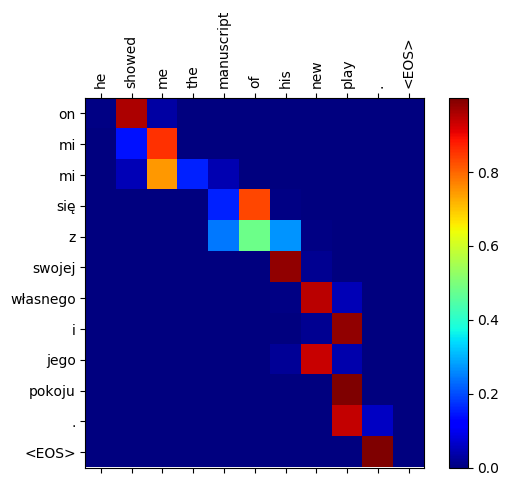

  2%|2               | 750/50000 [44:02<45:43:27,  3.34s/it]
44m 2s (- 2892m 13s) (750 1%) 2.9531
> i built this for you .
= zbudowałem go dla ciebie .
< kupiłem to dla ciebie . <EOS>


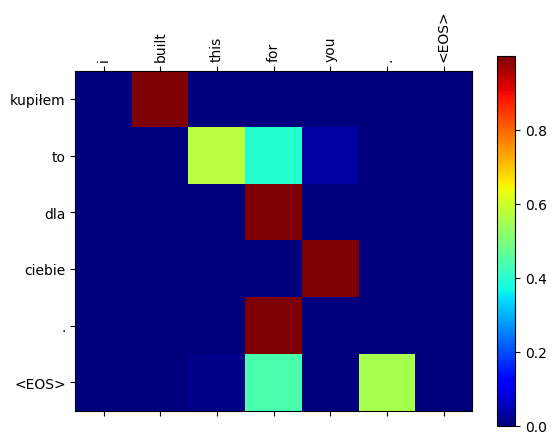

  2%|2               | 800/50000 [46:57<50:25:19,  3.69s/it]
46m 57s (- 2888m 12s) (800 1%) 2.7740
> i'm not joking .
= nie żartuję .
< nie jestem szczęśliwy . <EOS>


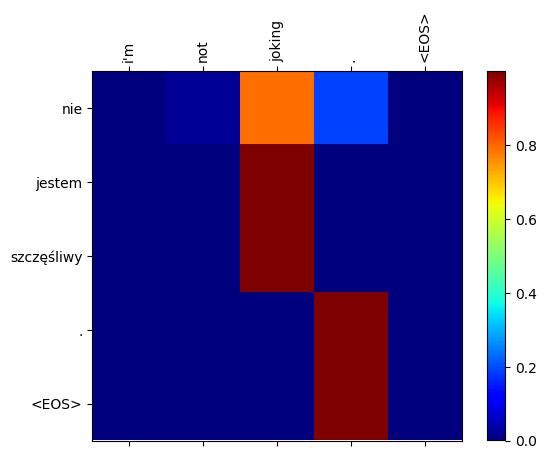

  2%|2               | 850/50000 [49:54<49:40:08,  3.64s/it]
49m 54s (- 2885m 49s) (850 1%) 2.7503
> i missed the train .
= spóźniłem się na pociąg .
< poszedłem się na pociąg . <EOS>


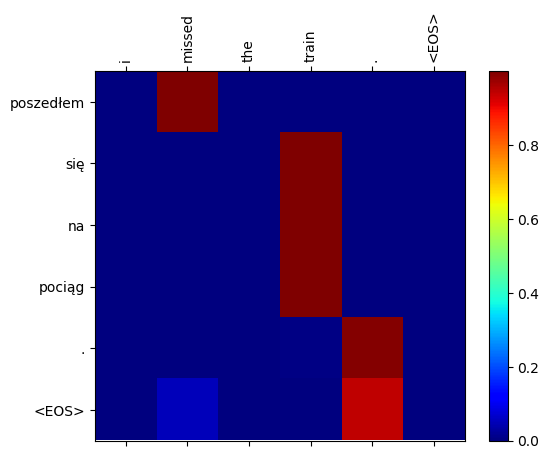

  2%|2               | 900/50000 [52:54<43:55:00,  3.22s/it]
52m 54s (- 2886m 13s) (900 1%) 2.6105
> i won't be able to fix that .
= nie będę w stanie tego naprawić .
< nie będę się tego więcej tego . <EOS>


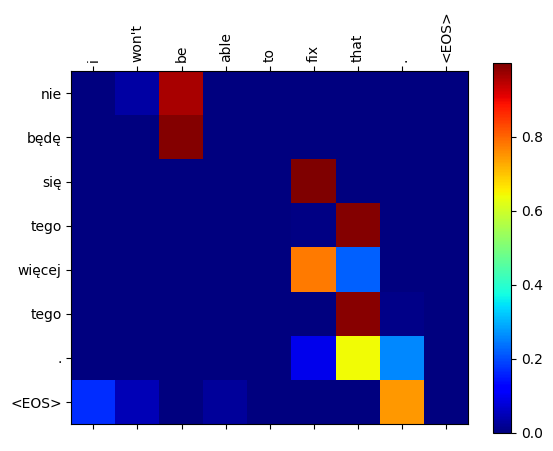

  2%|3               | 950/50000 [55:39<44:54:01,  3.30s/it]
55m 39s (- 2873m 38s) (950 1%) 2.5315
> the computer repair took all day .
= naprawa komputera zajęła cały dzień .
< ten odkurzacz nie spał wypadek . <EOS>


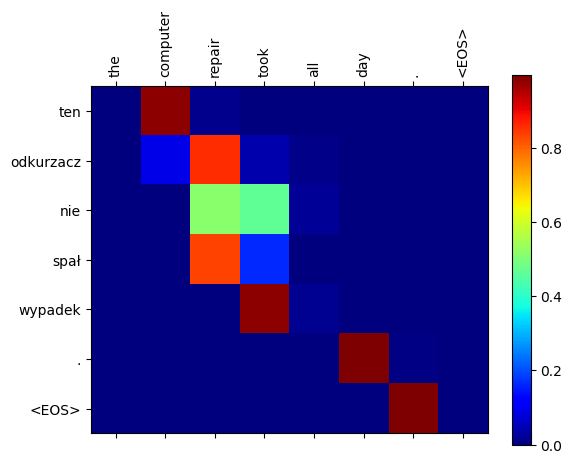

  2%|3              | 1000/50000 [58:45<45:05:46,  3.31s/it]
58m 45s (- 2879m 20s) (1000 2%) 2.4629
> tom is often the first one to arrive at a party and the last one to leave .
= tom często pierwszy przychodzi na imprezę i ostatni wychodzi .
< tom jest jedynym , że na przyjęciu i ostatni ostatni do bostonu . <EOS>


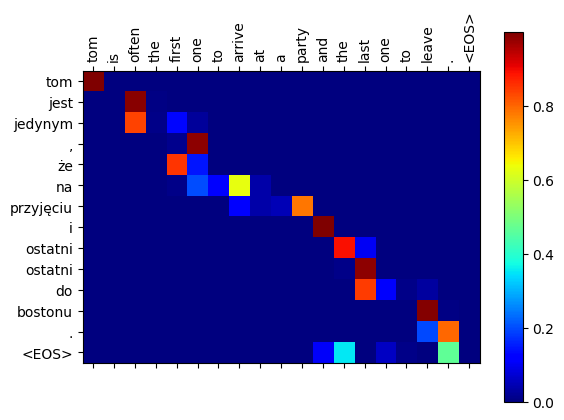

  2%|2            | 1050/50000 [1:01:40<40:20:32,  2.97s/it]
61m 40s (- 2875m 27s) (1050 2%) 2.4161
> tom won't call mary .
= tom nie zadzwoni do mary .
< tom nie mógł mary . <EOS>


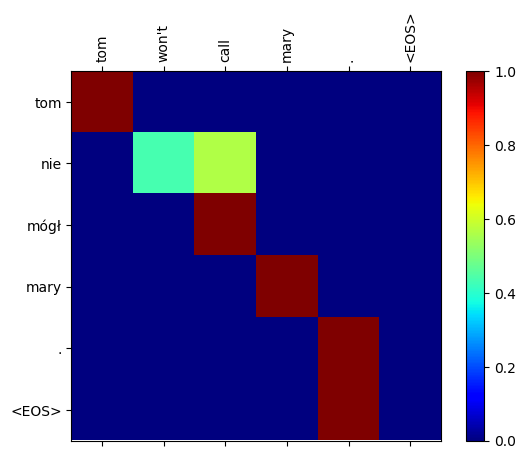

  2%|2            | 1100/50000 [1:04:48<56:34:32,  4.17s/it]
64m 48s (- 2880m 56s) (1100 2%) 2.3148
> for the lack of something better to do , tom decided to take a long walk .
= z braku czegoś lepszego do roboty , tom postanowił wybrać się na długi spacer .
< na film coś zrobić , żeby tom chciał się uczyć się do japonii . <EOS>


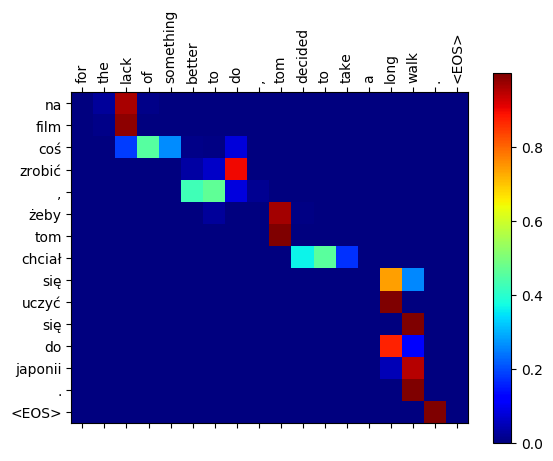

  2%|2            | 1150/50000 [1:07:44<49:46:39,  3.67s/it]
67m 44s (- 2877m 35s) (1150 2%) 2.2321
> it's the worst thing that could happen .
= to jest najgorsza rzecz jaka mogła się wydarzyć .
< to jest najgorsza , że to może się wydarzyć . <EOS>


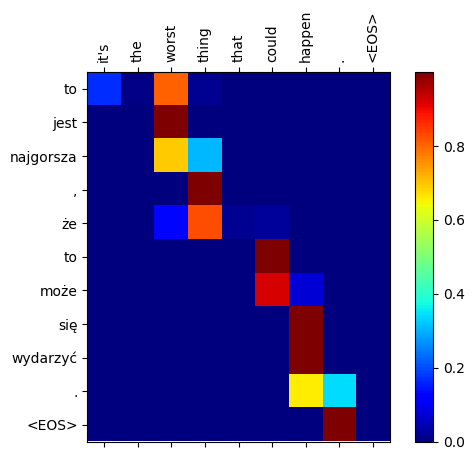

  2%|3            | 1200/50000 [1:10:45<55:02:12,  4.06s/it]
70m 45s (- 2877m 23s) (1200 2%) 2.1704
> here's my telephone number .
= to mój numer telefonu .
< mój mój numer mój numer . <EOS>


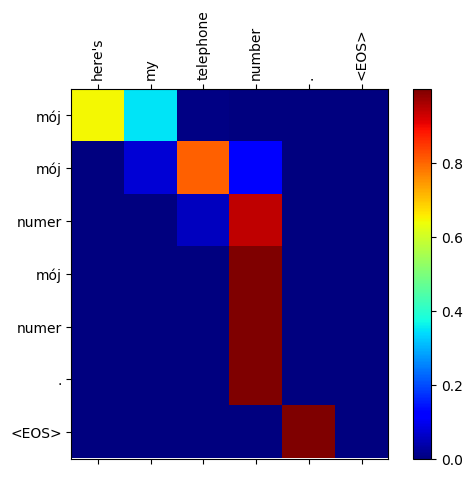

  2%|3            | 1250/50000 [1:13:34<46:27:08,  3.43s/it]
73m 34s (- 2869m 15s) (1250 2%) 2.0713
> your comic books are on the shelf .
= twoje komiksy są na półce .
< twoje płaszcz są na świecie . <EOS>


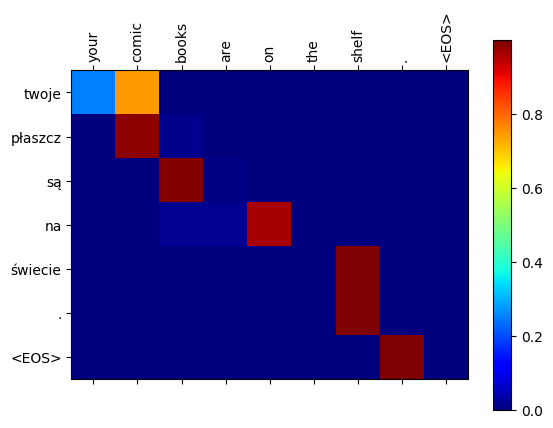

  3%|3            | 1300/50000 [1:16:12<49:07:25,  3.63s/it]
76m 12s (- 2855m 1s) (1300 2%) 2.0198
> i can't trust anyone .
= nie mogę nikomu ufać .
< nie mogę pozwolić . <EOS>


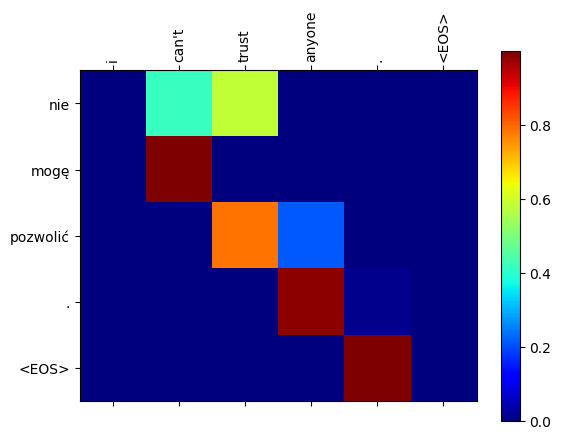

  3%|3            | 1350/50000 [1:19:12<49:13:21,  3.64s/it]
79m 12s (- 2854m 27s) (1350 2%) 1.9346
> tom wasn't able to talk to mary .
= tom nie mógł porozmawiać z mary .
< tom nie był rozmawiać z mary . <EOS>


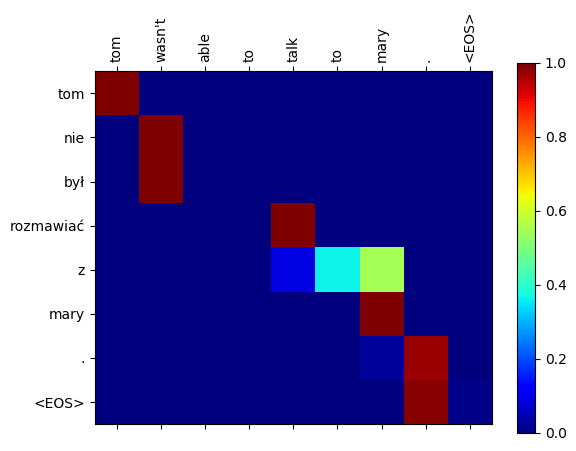

  3%|3            | 1400/50000 [1:22:09<49:59:45,  3.70s/it]
82m 9s (- 2852m 19s) (1400 2%) 1.9201
> what languages are spoken in america ?
= jakimi językami mówi się w ameryce ?
< co językami się w niemczech ? <EOS>


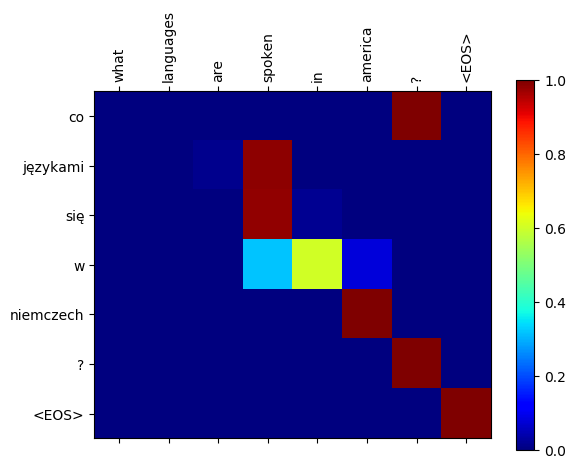

  3%|3            | 1450/50000 [1:25:09<46:52:42,  3.48s/it]
85m 9s (- 2851m 10s) (1450 2%) 1.9168
> i heard him go down the stairs .
= słyszałem jak schodził po schodach .
< słyszałem , jak wychodził . <EOS>


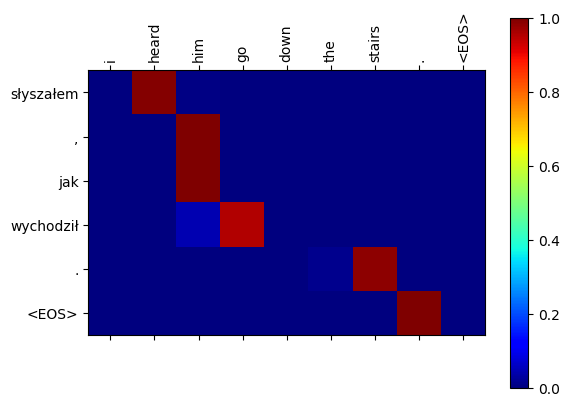

  3%|3            | 1500/50000 [1:28:07<50:07:02,  3.72s/it]
88m 7s (- 2849m 25s) (1500 3%) 1.7882
> you must be tired .
= na pewno jesteście zmęczeni .
< musisz być zmęczony . <EOS>


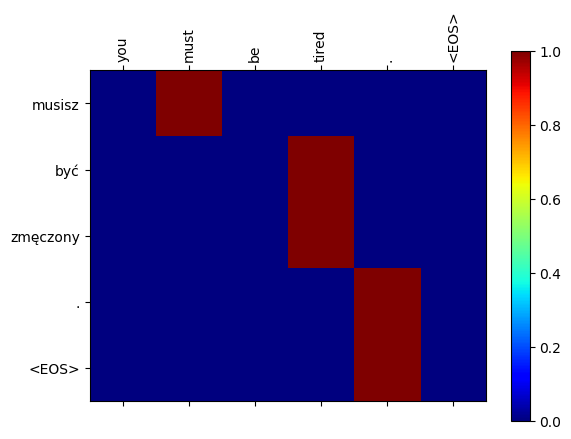

  3%|4            | 1550/50000 [1:31:14<46:26:22,  3.45s/it]
91m 14s (- 2851m 59s) (1550 3%) 1.7585
> can you remember the first word you learned in english ?
= czy pamiętasz swoje pierwsze angielskie słowo ?
< pamiętasz pierwszy pierwszy pierwszy pierwszy angielskiego ? <EOS>


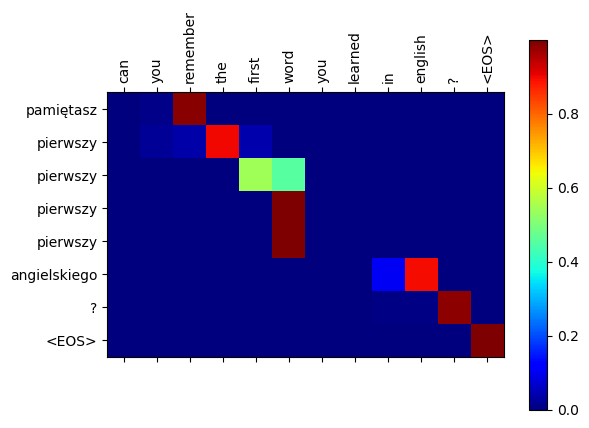

  3%|4            | 1600/50000 [1:34:04<52:10:27,  3.88s/it]
94m 4s (- 2845m 47s) (1600 3%) 1.7317
> it is very short .
= to jest bardzo krótkie .
< to bardzo bardzo krótkie . <EOS>


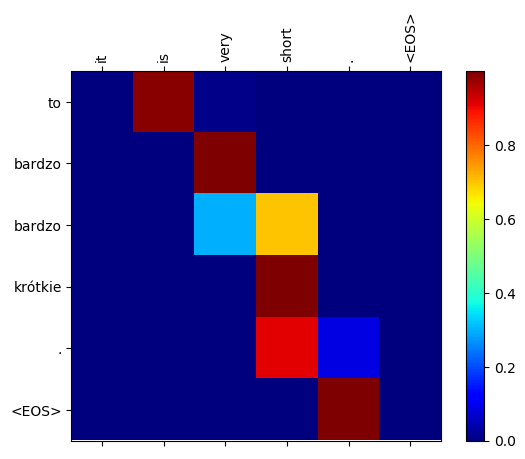

  3%|4            | 1650/50000 [1:37:05<43:33:43,  3.24s/it]
97m 5s (- 2845m 2s) (1650 3%) 1.7115
> we are at home .
= jesteśmy w domu .
< jesteśmy w domu . <EOS>


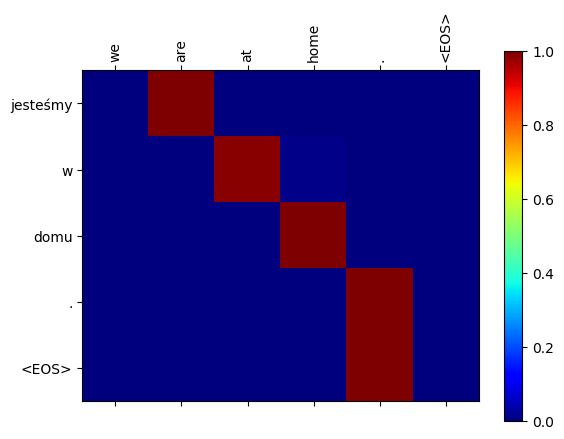

  3%|4            | 1700/50000 [1:39:58<37:40:24,  2.81s/it]
99m 58s (- 2840m 41s) (1700 3%) 1.5858
> i wish you'd stop asking me that .
= chciałbym , żebyś przestał mnie o to pytać .
< chciałbym mi , że się powiem . <EOS>


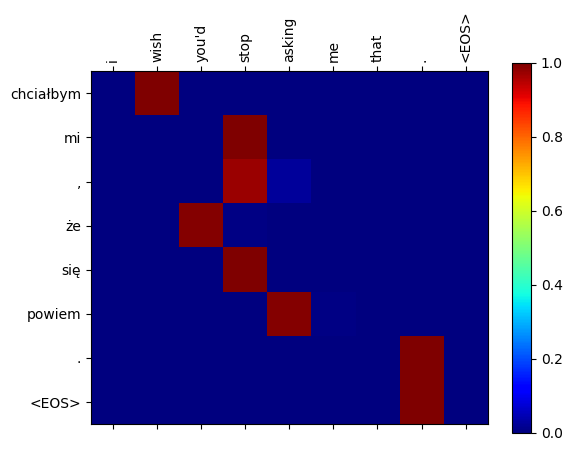

  4%|4            | 1750/50000 [1:42:41<42:44:24,  3.19s/it]
102m 41s (- 2831m 20s) (1750 3%) 1.5481
> i told tom to stay in his room .
= powiedziałem tom'owi aby został w swoim pokoju .
< powiedziałem tomowi , żeby zostać w swoim pokoju . <EOS>


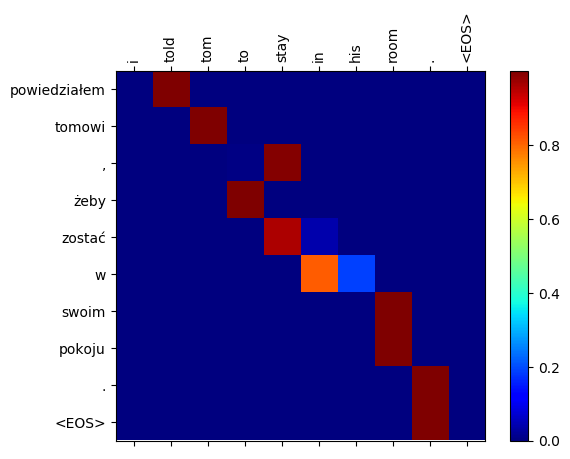

  4%|4            | 1800/50000 [1:45:36<47:51:21,  3.57s/it]
105m 36s (- 2828m 2s) (1800 3%) 1.5507
> tom never really wanted to go to harvard .
= tom nigdy naprawdę nie chciał iść na harvard .
< tom nigdy nie chciał jechać na harvard . <EOS>


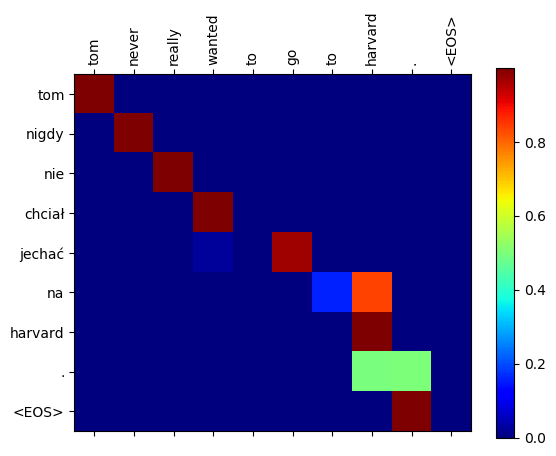

  4%|4            | 1850/50000 [1:48:36<44:13:02,  3.31s/it]
108m 36s (- 2826m 49s) (1850 3%) 1.5226
> things have gotten better now .
= sytuacja się poprawiła .
< to się jeszcze jeszcze teraz lepiej . <EOS>


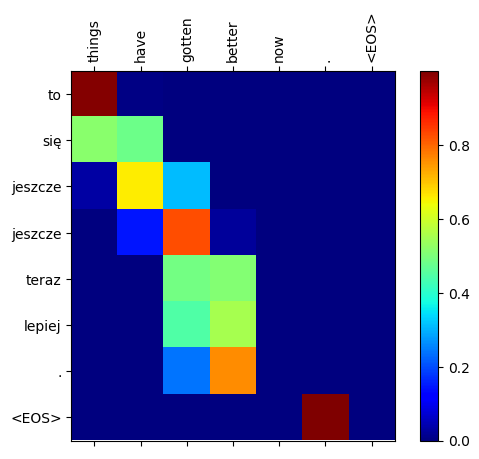

  4%|4            | 1900/50000 [1:51:36<46:16:39,  3.46s/it]
111m 36s (- 2825m 34s) (1900 3%) 1.4413
> bring me money .
= przynieś mi pieniądze .
< przynieś mi pieniądze . <EOS>


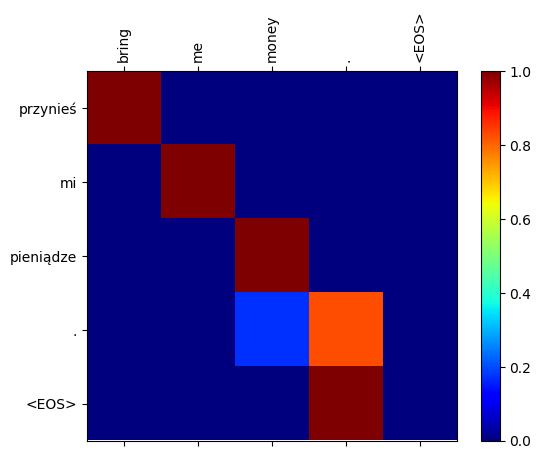

  4%|5            | 1950/50000 [1:54:21<43:57:45,  3.29s/it]
114m 21s (- 2817m 52s) (1950 3%) 1.4250
> he returned home for the first time in ten years .
= wrócił do domu po raz pierwszy od dziesięciu lat .
< wrócił do domu przez raz pierwszy w firmie . <EOS>


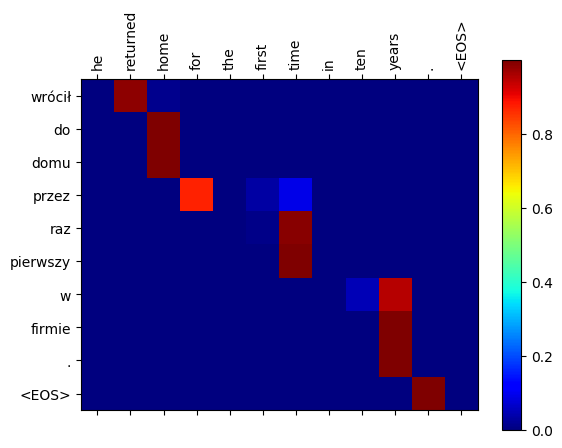

  4%|5            | 2000/50000 [1:57:16<38:10:28,  2.86s/it]
117m 16s (- 2814m 27s) (2000 4%) 1.3607
> do you think tom is lying to us ?
= myślisz , że tom nas okłamuje ?
< myślisz , że tom nas nie przyszedł ? <EOS>


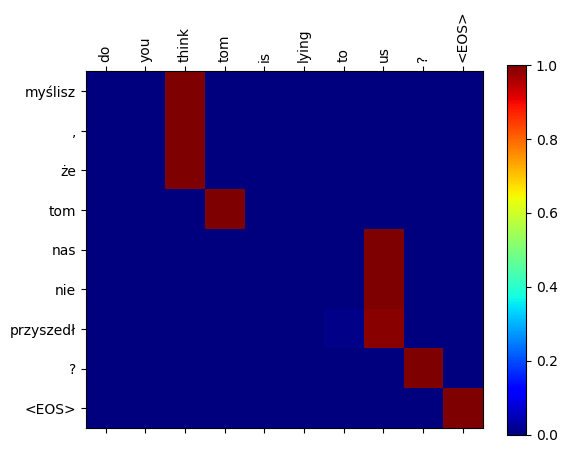

  4%|5            | 2050/50000 [2:00:08<40:33:02,  3.04s/it]
120m 8s (- 2810m 19s) (2050 4%) 1.3467
> give me that one .
= daj mi tamten .
< daj mi to jeden . <EOS>


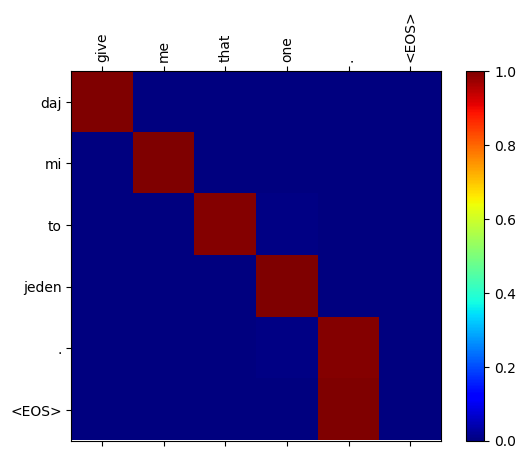

  4%|5            | 2100/50000 [2:02:59<48:49:42,  3.67s/it]
122m 59s (- 2805m 29s) (2100 4%) 1.3065
> i promise you i won't ever leave you .
= obiecuję , że nigdy cię nie zostawię .
< przyrzekam , że nie będę cię zostawię . <EOS>


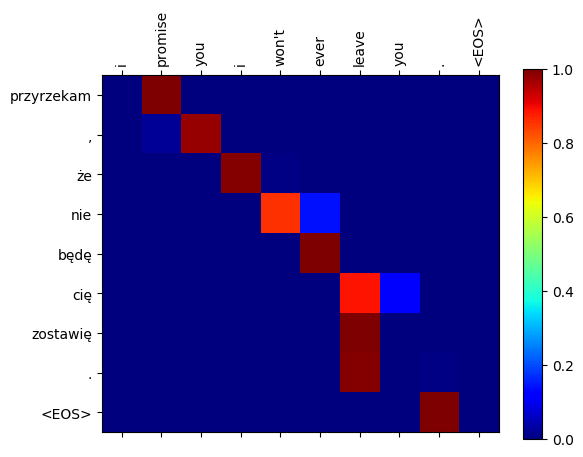

  4%|5            | 2150/50000 [2:05:56<41:39:41,  3.13s/it]
125m 56s (- 2803m 2s) (2150 4%) 1.3066
> you may stay .
= możesz zostać .
< możesz zostać . <EOS>


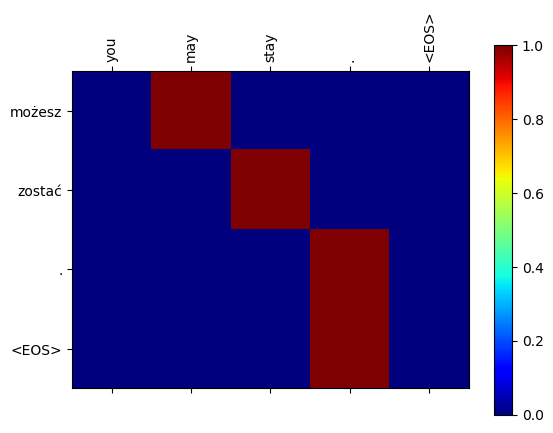

  4%|5            | 2200/50000 [2:08:48<43:58:05,  3.31s/it]
128m 48s (- 2798m 33s) (2200 4%) 1.2674
> i got the impression you didn't like me .
= odniosłem wrażenie , że mnie nie lubisz .
< dostałem , że mnie nie lubisz . <EOS>


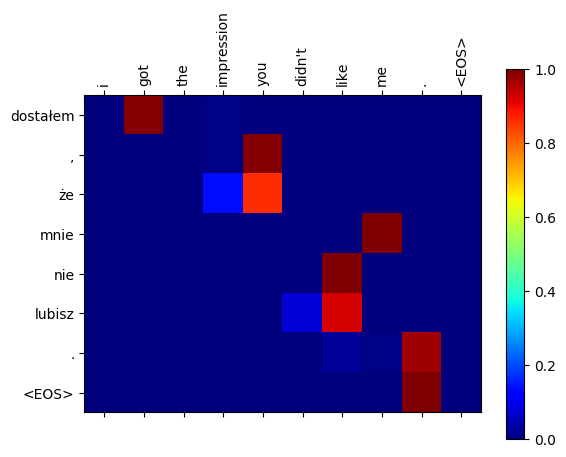

  4%|5            | 2250/50000 [2:11:45<51:49:27,  3.91s/it]
131m 45s (- 2796m 5s) (2250 4%) 1.2074
> i was too drunk .
= byłem zbyt pijany .
< byłem zbyt pijany . <EOS>


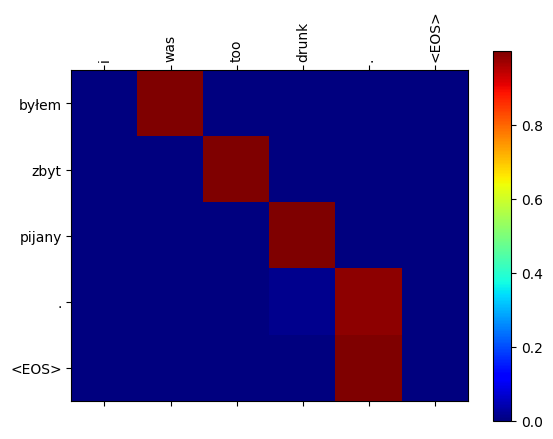

  5%|5            | 2300/50000 [2:14:59<51:24:38,  3.88s/it]
134m 59s (- 2799m 27s) (2300 4%) 1.2141
> tom can't hurt me .
= tom nic mi nie może zrobić .
< tom nie może mnie zranić . <EOS>


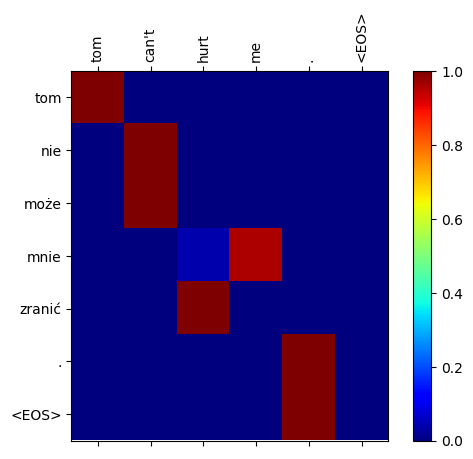

  5%|6            | 2350/50000 [2:17:54<45:51:08,  3.46s/it]
137m 54s (- 2796m 11s) (2350 4%) 1.1831
> he does speak well .
= on naprawdę dobrze mówi .
< on dobrze dobrze . <EOS>


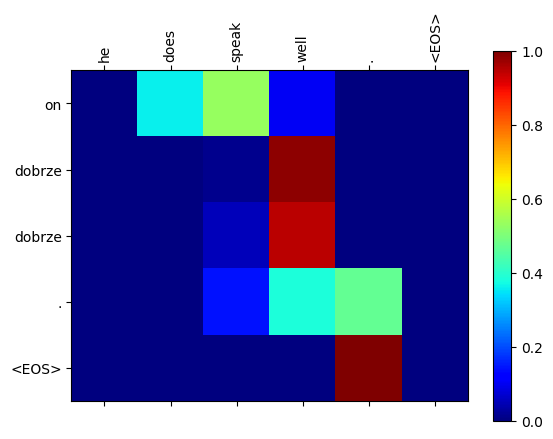

  5%|6            | 2400/50000 [2:20:45<48:44:11,  3.69s/it]
140m 45s (- 2791m 38s) (2400 4%) 1.1566
> it's time for a fresh start .
= czas na nowy początek .
< czas na początku początek . <EOS>


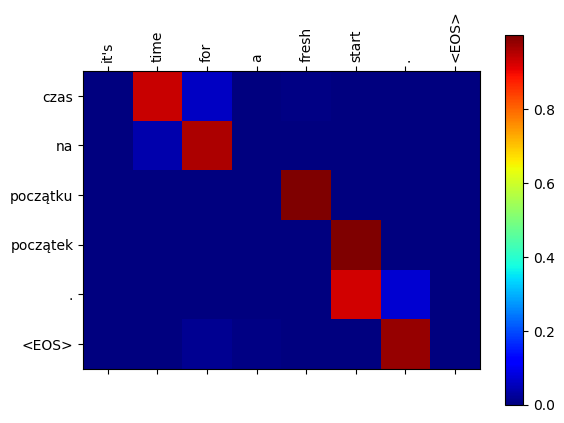

  5%|6            | 2450/50000 [2:23:39<40:03:17,  3.03s/it]
143m 39s (- 2788m 7s) (2450 4%) 1.1064
> he works in a factory .
= pracuje w fabryce .
< pracuje w fabryce . <EOS>


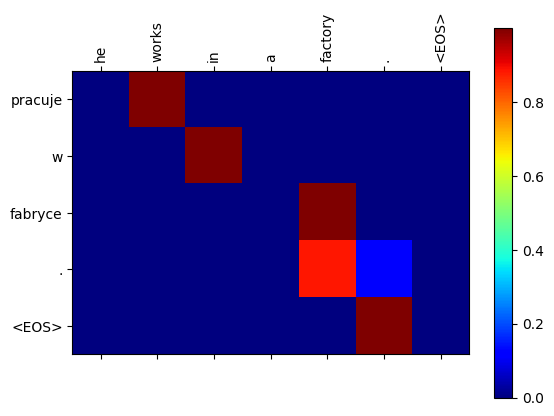

  5%|6            | 2500/50000 [2:26:25<39:38:12,  3.00s/it]
146m 25s (- 2781m 58s) (2500 5%) 1.0710
> how long have you been in japan ?
= od jak dawna jesteś w japonii ?
< jak długo masz w japonii ? <EOS>


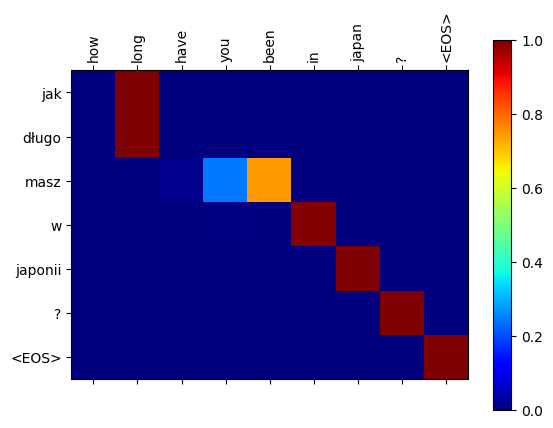

  5%|6            | 2550/50000 [2:29:21<57:01:26,  4.33s/it]
149m 21s (- 2779m 16s) (2550 5%) 1.0972
> how's tom going to do it ?
= jak tom zamierza to zrobić ?
< jak tom to zrobić ? <EOS>


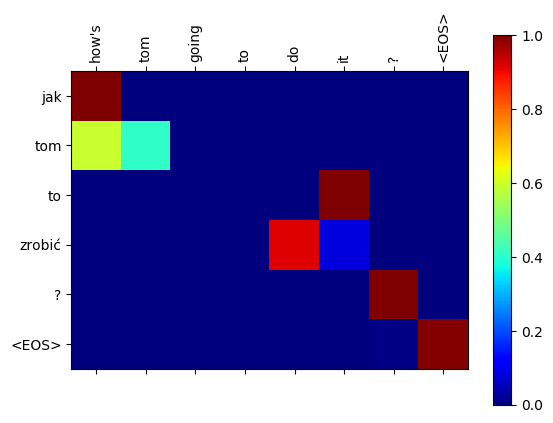

  5%|6            | 2600/50000 [2:32:32<48:40:20,  3.70s/it]
152m 32s (- 2780m 55s) (2600 5%) 1.0446
> at first , i couldn't play the guitar .
= z początku nie umiałem grać na gitarze .
< w pierwsze , nie mogłem grać na gitarze . <EOS>


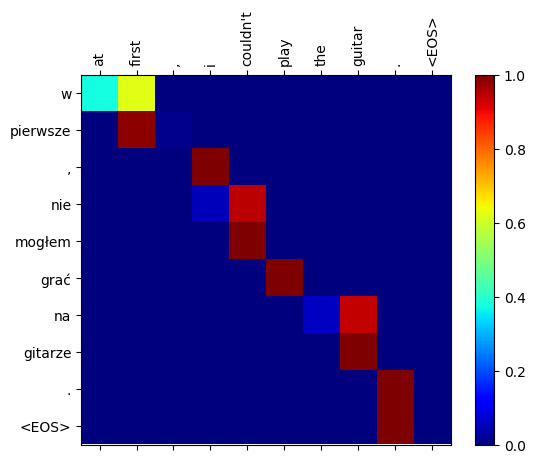

  5%|6            | 2650/50000 [2:35:23<46:29:24,  3.53s/it]
155m 23s (- 2776m 35s) (2650 5%) 1.0102
> this is free .
= to jest za darmo .
< to jest za darmo . <EOS>


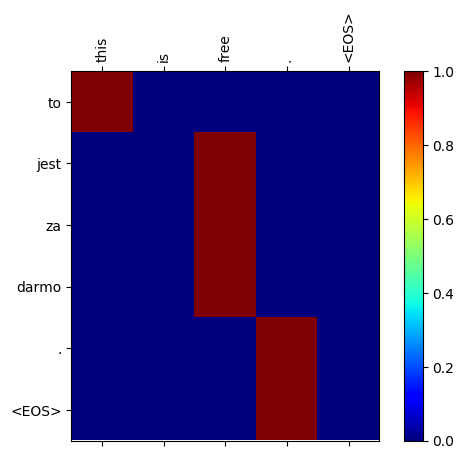

  5%|7            | 2700/50000 [2:38:27<46:07:27,  3.51s/it]
158m 27s (- 2776m 1s) (2700 5%) 1.0084
> my dog was hit by a car .
= mój pies był potrącony przez samochód .
< mój pies był potrącony przez samochód . <EOS>


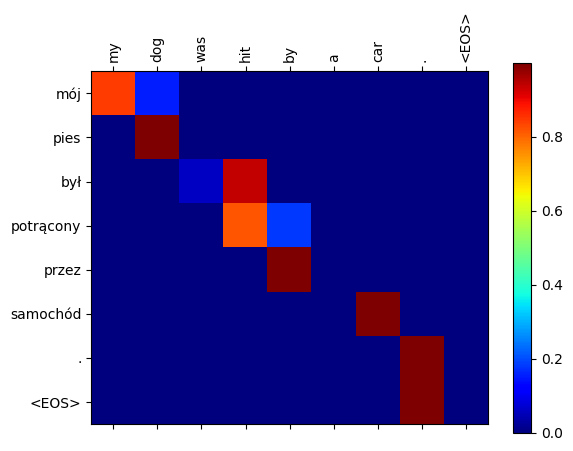

  6%|7            | 2750/50000 [2:41:24<53:24:30,  4.07s/it]
161m 24s (- 2773m 12s) (2750 5%) 0.9374
> mastering a foreign language calls for patience .
= opanowanie języka obcego wymaga cierpliwości .
< niektórzy międzynarodowy za nową sukienkę . <EOS>


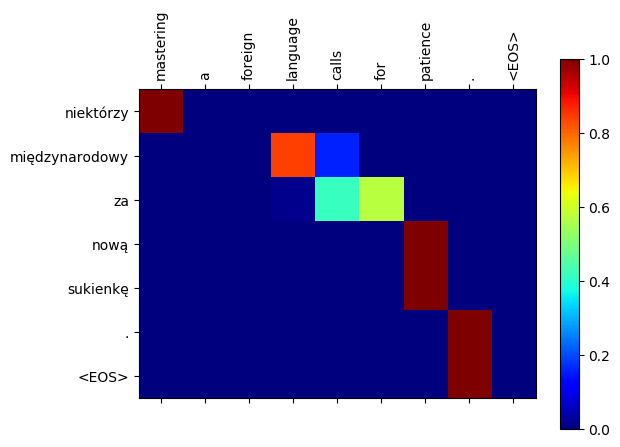

  6%|7            | 2800/50000 [2:44:31<42:59:37,  3.28s/it]
164m 31s (- 2773m 31s) (2800 5%) 0.9564
> it takes a great deal of practice to master a foreign language .
= aby opanować obcy język , trzeba mnóstwo ćwiczeń .
< to opanować , których o zostaniu wymaga się śmiać . <EOS>


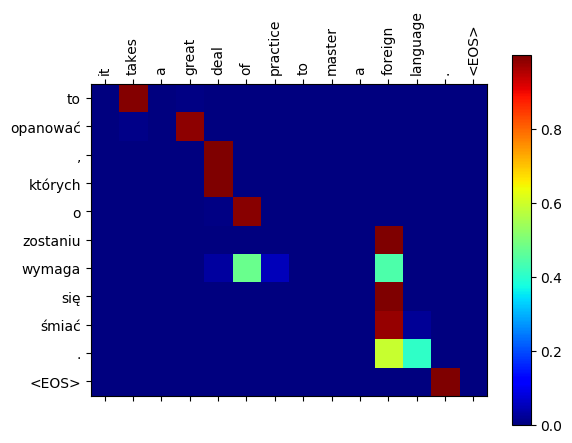

  6%|7            | 2850/50000 [2:47:23<45:37:11,  3.48s/it]
167m 23s (- 2769m 23s) (2850 5%) 0.9450
> all in all , i enjoyed the lecture .
= wykład był w sumie fajny .
< wszyscy cały cały za tym , co robię . <EOS>


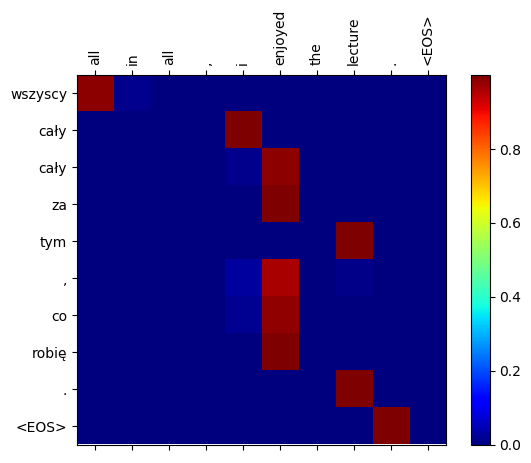

  6%|7            | 2900/50000 [2:50:11<46:24:49,  3.55s/it]
170m 11s (- 2764m 1s) (2900 5%) 0.8902
> he lay down on his back .
= położył się na plecach .
< położył się na plecach . <EOS>


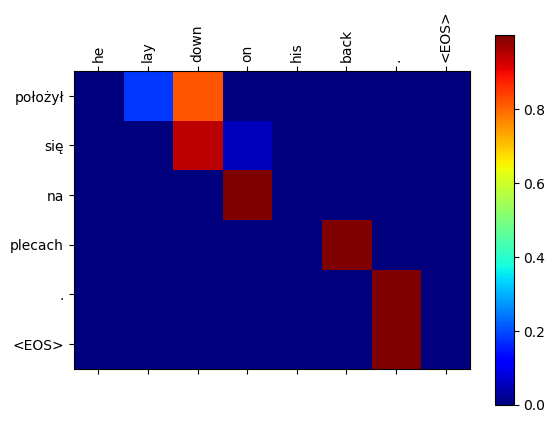

  6%|7            | 2950/50000 [2:53:03<40:50:15,  3.12s/it]
173m 3s (- 2760m 9s) (2950 5%) 0.9018
> he is angry with me .
= gniewa się na mnie .
< on jest na mnie zły . <EOS>


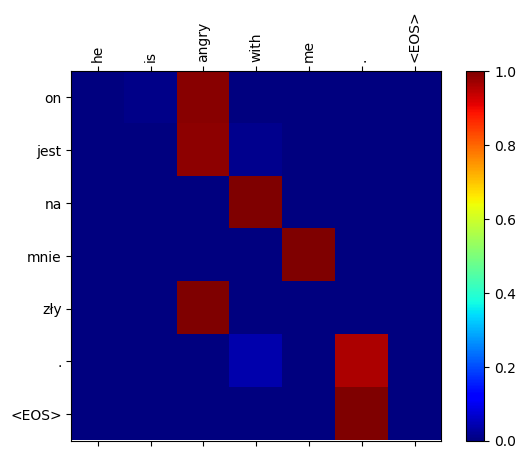

  6%|7            | 3000/50000 [2:55:56<45:48:36,  3.51s/it]
175m 56s (- 2756m 29s) (3000 6%) 0.8293
> tom was worried about you .
= tom się o ciebie martwił .
< tom był o ciebie martwił . <EOS>


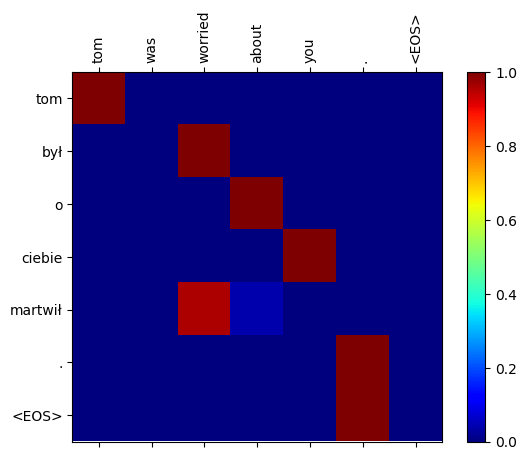

  6%|7            | 3050/50000 [2:58:39<36:09:22,  2.77s/it]
178m 39s (- 2750m 5s) (3050 6%) 0.8368
> mary used to be beautiful .
= mary była piękna .
< mary mieszkała być piękna . <EOS>


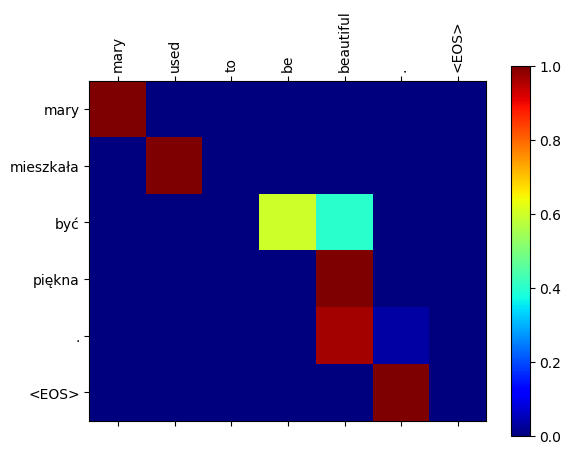

  6%|8            | 3100/50000 [3:01:30<41:13:58,  3.16s/it]
181m 30s (- 2746m 3s) (3100 6%) 0.8459
> i like trains .
= lubię pociągi .
< lubię pociągi . <EOS>


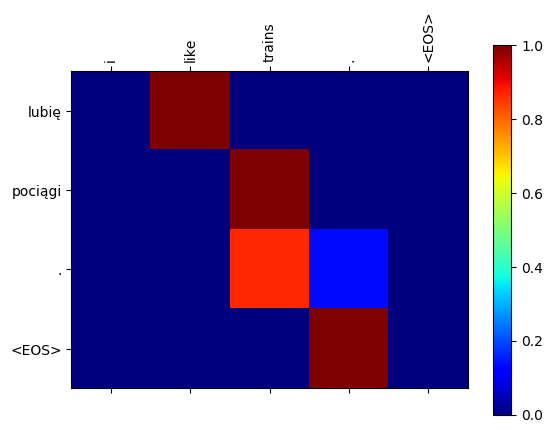

  6%|8            | 3150/50000 [3:04:25<36:38:14,  2.82s/it]
184m 25s (- 2742m 50s) (3150 6%) 0.8030
> i talked on the telephone .
= rozmawiałem przez telefon .
< rozmawiałem na telefon . <EOS>


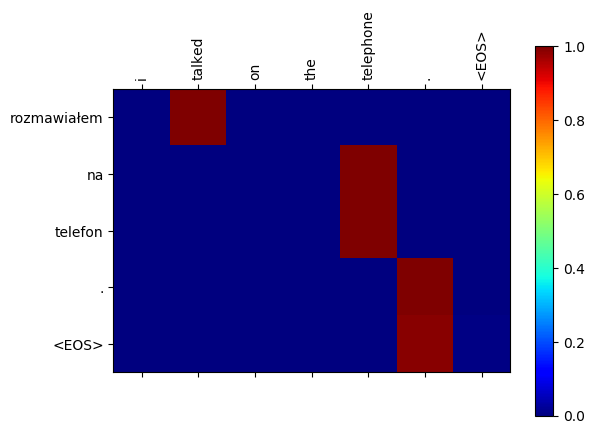

  6%|8            | 3200/50000 [3:07:34<48:28:55,  3.73s/it]
187m 34s (- 2743m 20s) (3200 6%) 0.8146
> i'll be there tomorrow .
= będę tam jutro .
< będę tam jutro . <EOS>


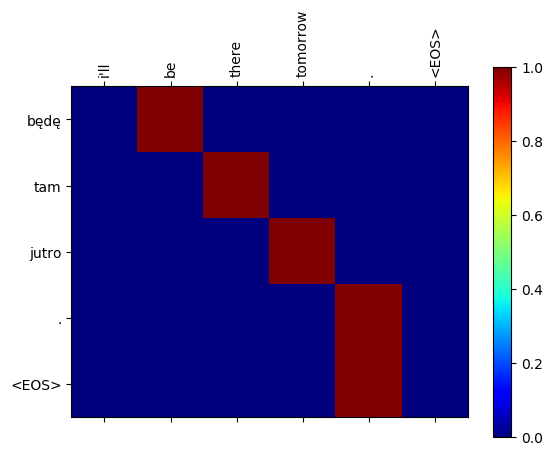

  6%|8            | 3250/50000 [3:10:33<62:39:22,  4.82s/it]
190m 33s (- 2741m 5s) (3250 6%) 0.7922
> do you have to do it now ?
= masz to zrobić teraz ?
< masz to zrobić teraz ? <EOS>


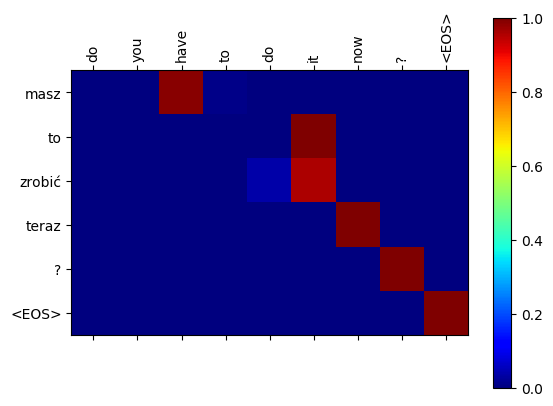

  7%|8            | 3300/50000 [3:13:35<52:00:14,  4.01s/it]
193m 35s (- 2739m 32s) (3300 6%) 0.7533
> she needs a coat .
= potrzebuje płaszcza .
< potrzebuje płaszcza . <EOS>


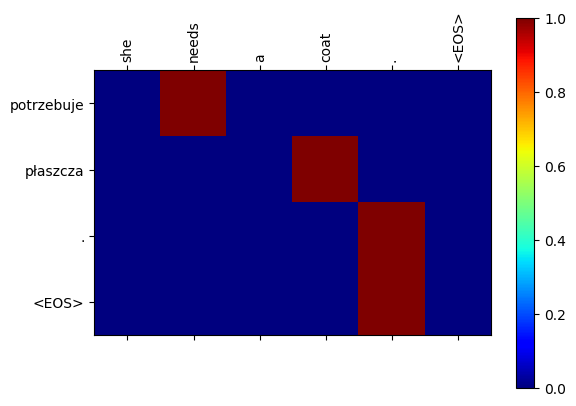

  7%|8            | 3350/50000 [3:16:27<40:37:13,  3.13s/it]
196m 27s (- 2735m 46s) (3350 6%) 0.7567
> he broke into a house .
= włamał się do domu .
< włamał się do domu . <EOS>


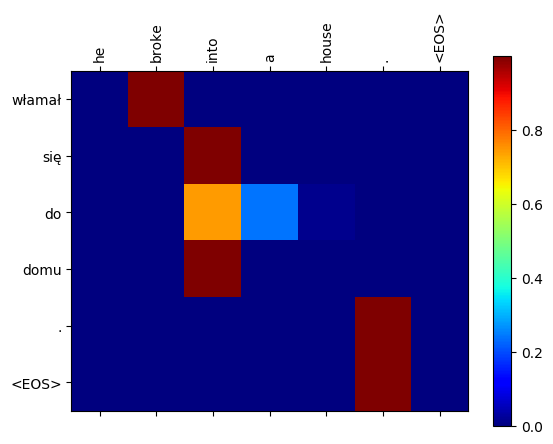

  7%|8            | 3400/50000 [3:19:27<45:56:46,  3.55s/it]
199m 27s (- 2733m 42s) (3400 6%) 0.7676
> how did you spend your free time ?
= jak spędziłeś wolny czas ?
< jak spędziłeś wolny czas ? <EOS>


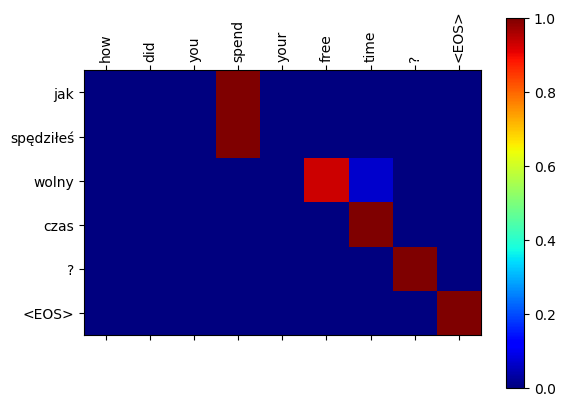

  7%|8            | 3450/50000 [3:22:29<45:42:35,  3.54s/it]
202m 29s (- 2732m 12s) (3450 6%) 0.7575
> did you do your homework ?
= odrobiłeś swoje zadanie domowe ?
< odrobiłeś swoje zadanie domowe ? <EOS>


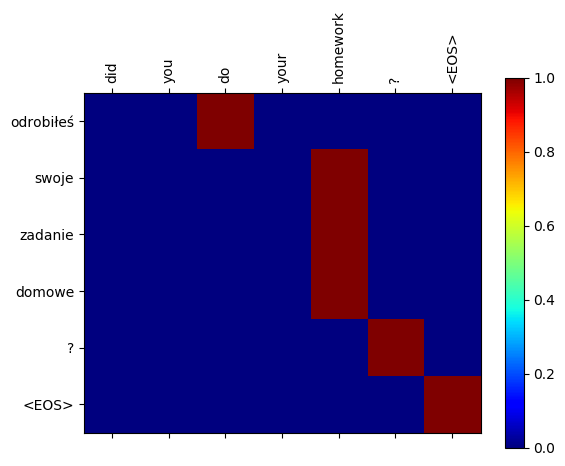

  7%|9            | 3500/50000 [3:25:24<42:17:37,  3.27s/it]
205m 24s (- 2728m 56s) (3500 7%) 0.7191
> it's wednesday .
= dziś jest środa .
< to jest środa . <EOS>


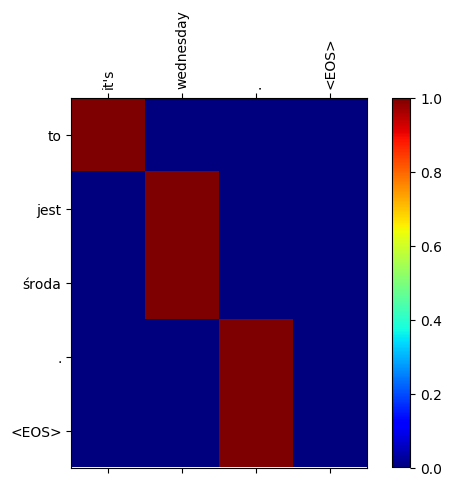

  7%|9            | 3550/50000 [3:28:27<51:17:45,  3.98s/it]
208m 27s (- 2727m 31s) (3550 7%) 0.6868
> he suddenly rose from the chair .
= nagle wstał z krzesła .
< nagle wstał z krzesła . <EOS>


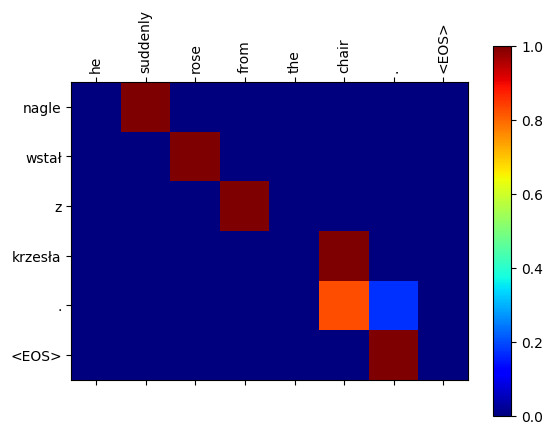

  7%|9            | 3600/50000 [3:31:20<40:27:16,  3.14s/it]
211m 20s (- 2723m 57s) (3600 7%) 0.6753
> tom has to be home by 2:30 .
= tom musi być w domu przed 2:30 .
< tom musi być w domu przed 2:30 . <EOS>


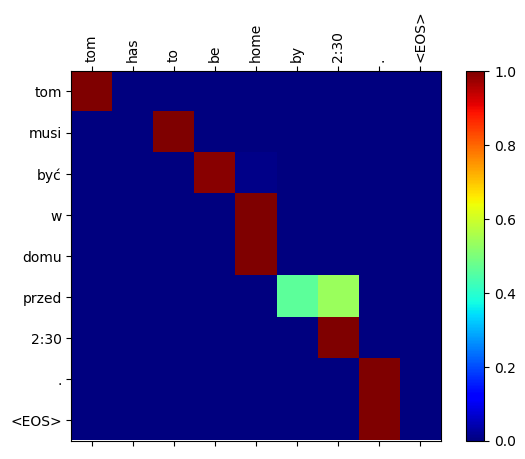

  7%|9            | 3650/50000 [3:34:22<53:43:04,  4.17s/it]
214m 22s (- 2722m 12s) (3650 7%) 0.6730
> i see a pattern .
= widzę wzór .
< widzę wzór . <EOS>


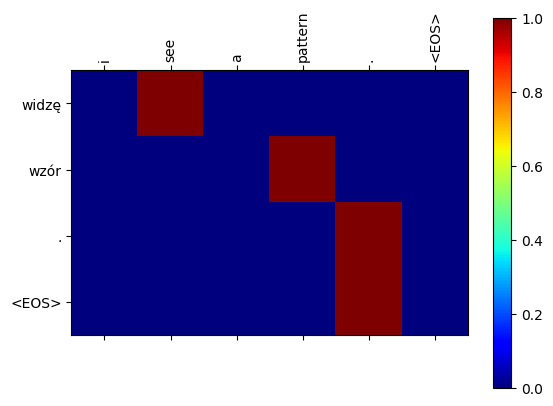

  7%|9            | 3700/50000 [3:37:25<50:48:00,  3.95s/it]
217m 25s (- 2720m 50s) (3700 7%) 0.6645
> tom wanted to get out of jail .
= tom chciał wyjść z więzienia .
< tom chciał wyjść z więzienia . <EOS>


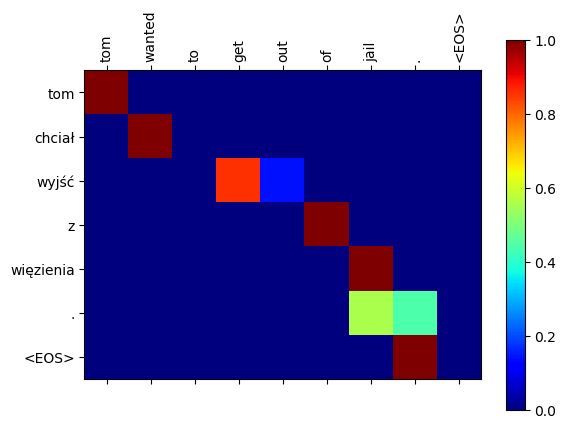

  8%|9            | 3750/50000 [3:40:27<49:57:17,  3.89s/it]
220m 27s (- 2718m 58s) (3750 7%) 0.6180
> i'm glad you came .
= cieszę się , że przyszedłeś .
< cieszę się , że przyszedłeś . <EOS>


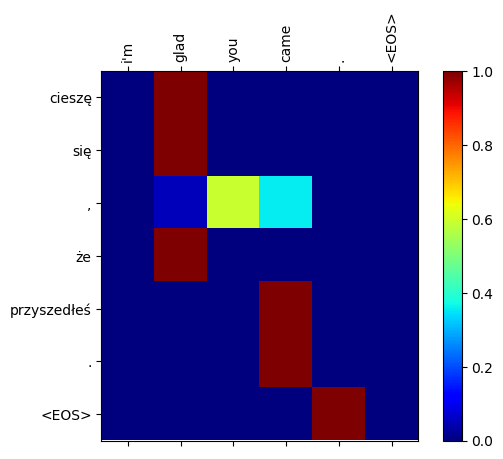

  8%|9            | 3800/50000 [3:43:16<38:47:42,  3.02s/it]
223m 16s (- 2714m 34s) (3800 7%) 0.6068
> how long does it take to get to the station ?
= jak długo zajmuje dojście do stacji ?
< jak długo zajmuje dojście do stacji ? <EOS>


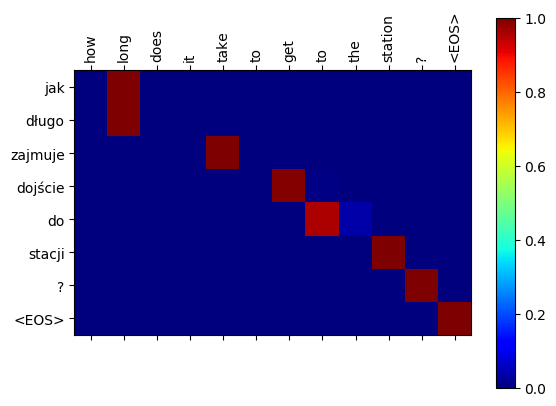

  8%|#            | 3850/50000 [3:46:09<45:01:51,  3.51s/it]
226m 9s (- 2711m 2s) (3850 7%) 0.6108
> do you have any ideas about it ?
= masz o tym jakieś pojęcie ?
< masz jakieś pojęcie o tym ? <EOS>


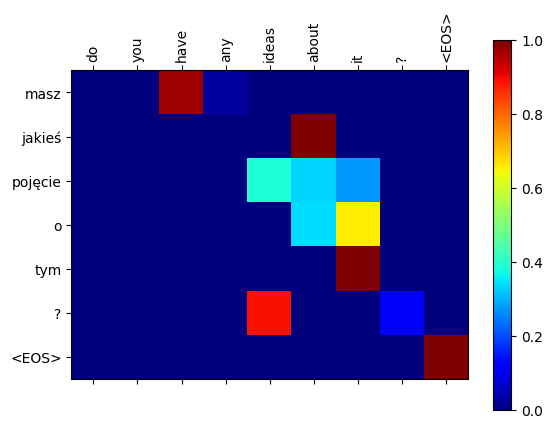

  8%|#            | 3900/50000 [3:49:16<38:55:46,  3.04s/it]
229m 16s (- 2710m 4s) (3900 7%) 0.6211
> what was the first word you learned in french ?
= jakie było pierwsze francuskie słowo którego się nauczyłaś ?
< jakie było pierwsze francuskie słowo którego się nauczyłaś ? <EOS>


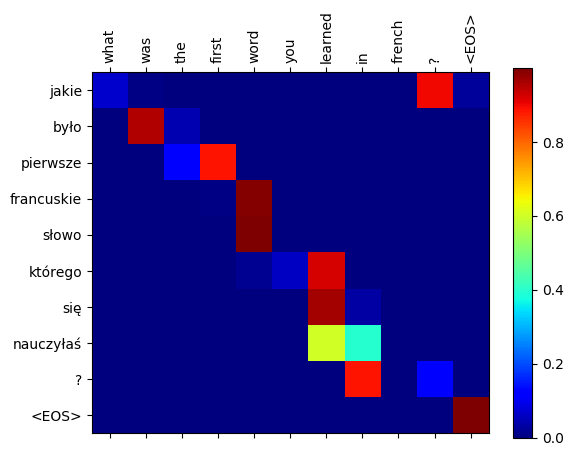

  8%|#            | 3950/50000 [3:52:12<41:16:40,  3.23s/it]
232m 12s (- 2707m 7s) (3950 7%) 0.5909
> watch how i do it .
= patrz jak ja to robię .
< patrz jak to robię . <EOS>


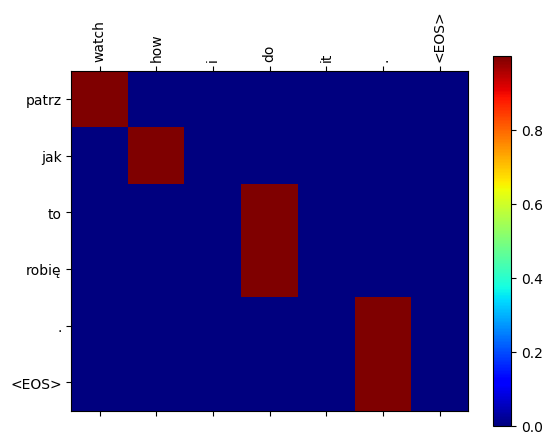

  8%|#            | 4000/50000 [3:55:11<46:12:27,  3.62s/it]
235m 11s (- 2704m 38s) (4000 8%) 0.5892
> tom isn't mary's boyfriend .
= tom nie jest chłopakiem mary .
< tom nie jest chłopakiem mary . <EOS>


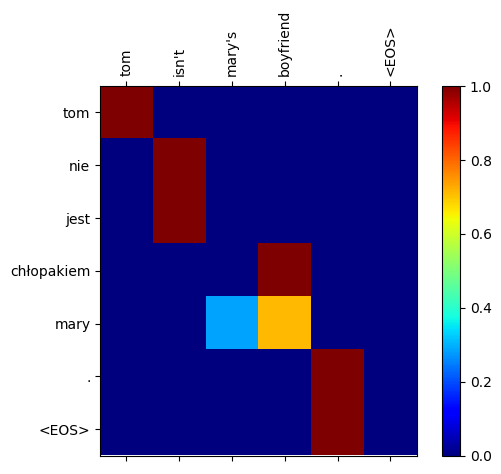

  8%|#            | 4050/50000 [3:58:02<39:56:11,  3.13s/it]
238m 2s (- 2700m 40s) (4050 8%) 0.5614
> you're good at what you do .
= jesteś dobry w tym , co robisz .
< jesteś dobry w tym , co robisz . <EOS>


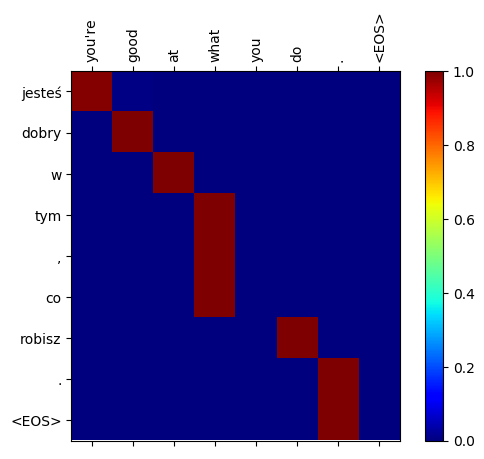

  8%|#            | 4100/50000 [4:01:05<42:20:50,  3.32s/it]
241m 5s (- 2699m 8s) (4100 8%) 0.5557
> we played basketball in the gym .
= graliśmy w koszykówkę na sali gimnastycznej .
< graliśmy w koszykówkę na sali gimnastycznej . <EOS>


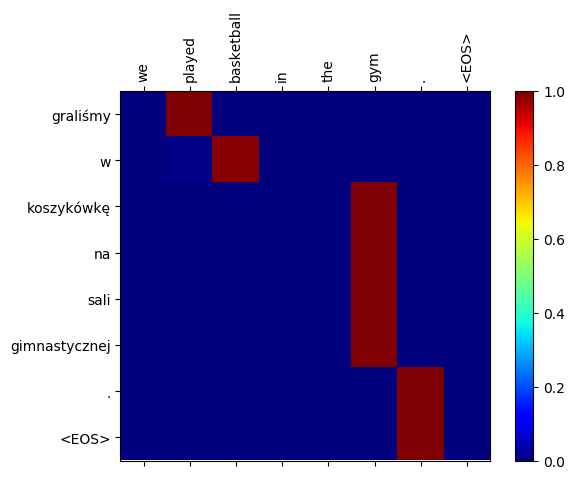

  8%|#            | 4150/50000 [4:04:02<54:31:29,  4.28s/it]
244m 2s (- 2696m 9s) (4150 8%) 0.5617
> i'm at the gym .
= jestem na siłowni .
< jestem na siłowni . <EOS>


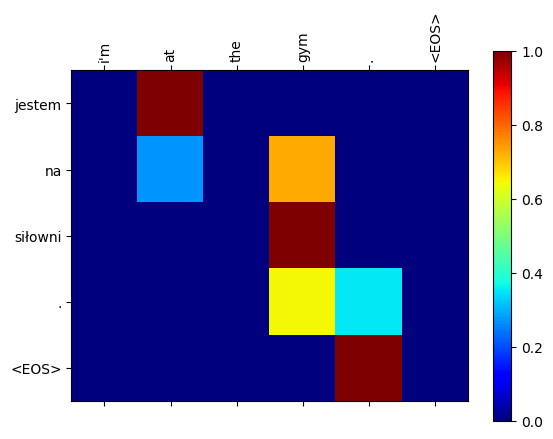

  8%|#            | 4200/50000 [4:06:55<46:37:05,  3.66s/it]
246m 55s (- 2692m 34s) (4200 8%) 0.5283
> do you still love tom ?
= wciąż kochasz toma ?
< wciąż kochasz toma ? <EOS>


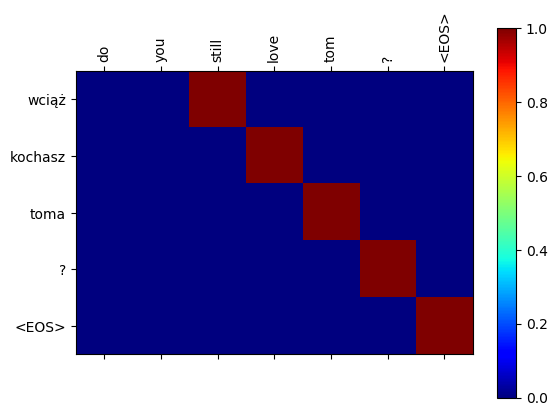

  8%|#1           | 4250/50000 [4:09:52<37:29:06,  2.95s/it]
249m 52s (- 2689m 53s) (4250 8%) 0.5174
> beware of pickpockets .
= uważaj na kieszonkowców .
< uwaga o kieszonkowców . <EOS>


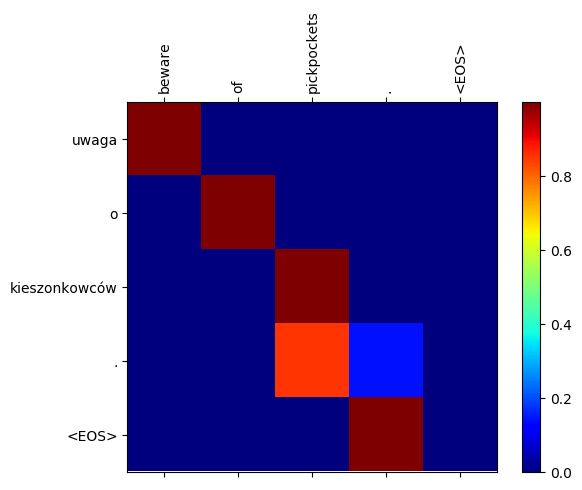

  9%|#1           | 4300/50000 [4:12:50<49:04:29,  3.87s/it]
252m 50s (- 2687m 14s) (4300 8%) 0.5031
> the wind is blowing hard now .
= wiatr wieje już długo i mocno .
< wiatr wieje teraz lepiej . <EOS>


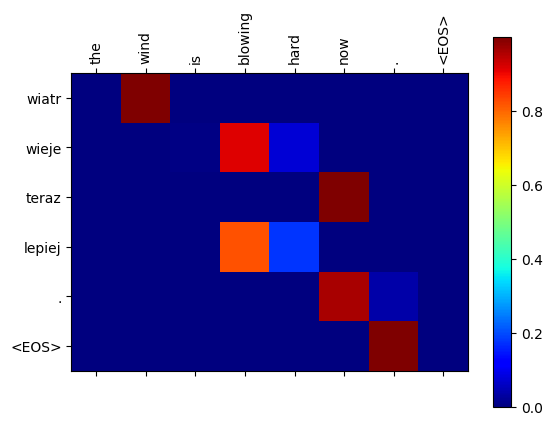

  9%|#1           | 4350/50000 [4:15:40<42:16:35,  3.33s/it]
255m 40s (- 2683m 9s) (4350 8%) 0.5044
> something must have happened to him on the way .
= musiało coś mu się przydarzyć po drodze .
< musiało musiało się , by się go przydarzyć , żeby go pójść . <EOS>


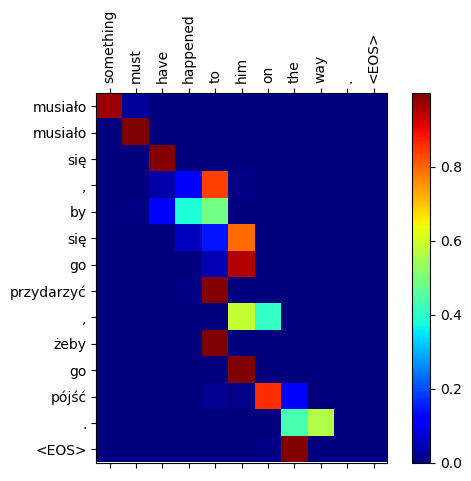

  9%|#1           | 4400/50000 [4:18:31<39:41:29,  3.13s/it]
258m 31s (- 2679m 13s) (4400 8%) 0.4845
> i'd like to talk with you about tom .
= chciałabym porozmawiać z tobą o tomie .
< chciałbym porozmawiać z wami o tomie . <EOS>


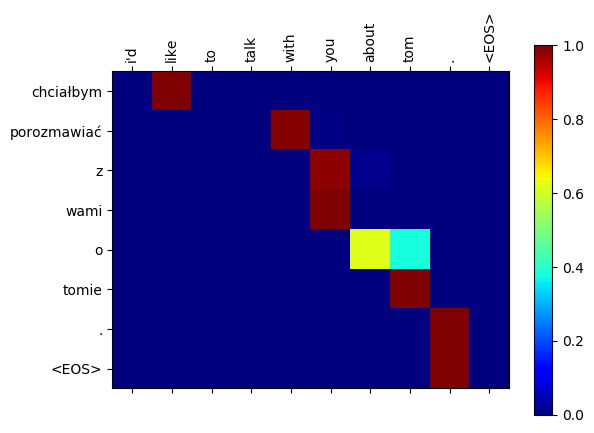

  9%|#1           | 4450/50000 [4:21:25<50:25:05,  3.98s/it]
261m 25s (- 2675m 57s) (4450 8%) 0.4779
> it's the anniversary of the end of the war .
= to jest rocznica końca wojny .
< to jest rocznica wojny wojny . <EOS>


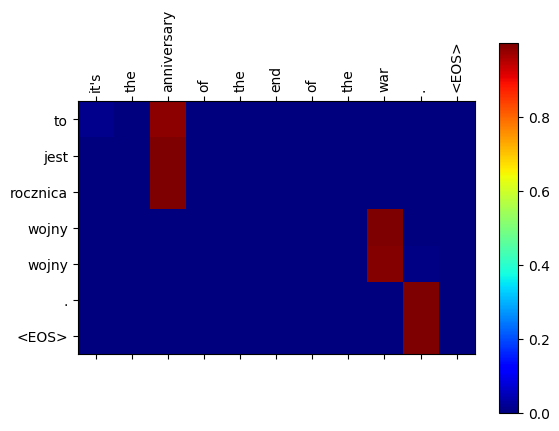

  9%|#1           | 4500/50000 [4:24:21<44:55:05,  3.55s/it]
264m 21s (- 2673m 1s) (4500 9%) 0.4795
> don't get fat .
= nie zrób się gruby .
< nie zniechęcaj się . <EOS>


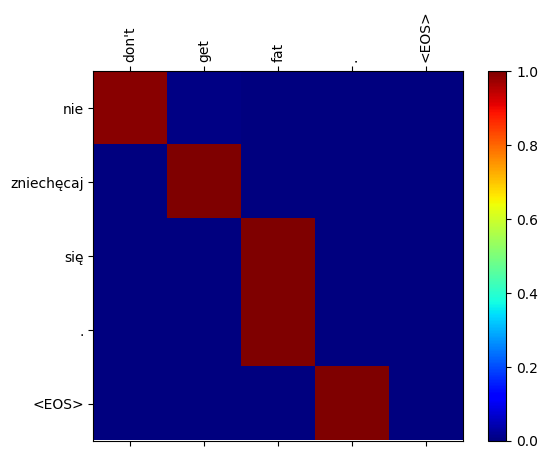

  9%|#1           | 4550/50000 [4:27:32<36:53:35,  2.92s/it]
267m 32s (- 2672m 30s) (4550 9%) 0.4491
> follow tom .
= śledź toma .
< śledź toma . <EOS>


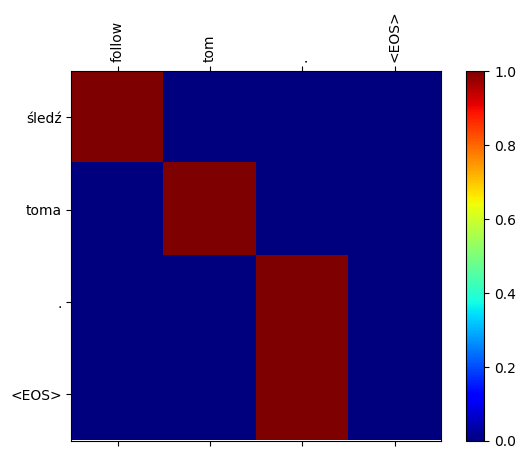

  9%|#1           | 4600/50000 [4:30:21<43:18:56,  3.43s/it]
270m 21s (- 2668m 19s) (4600 9%) 0.4603
> we are on good terms with them .
= jesteśmy z nimi w dobrych stosunkach .
< jesteśmy w dobrych stosunkach z nich . <EOS>


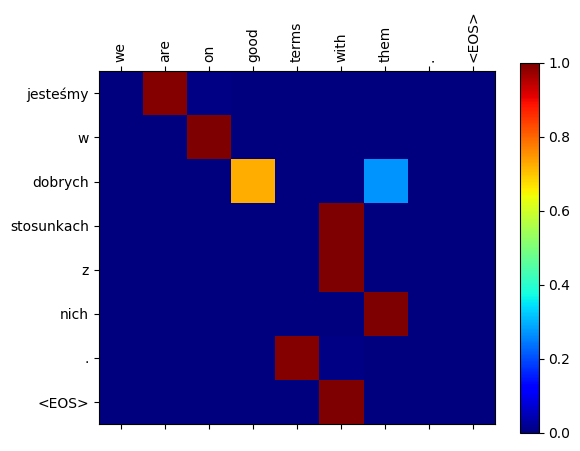

  9%|#2           | 4650/50000 [4:33:18<42:16:55,  3.36s/it]
273m 18s (- 2665m 30s) (4650 9%) 0.4696
> can you help tom ?
= możesz pomóc tomowi ?
< możesz pomóc tomowi ? <EOS>


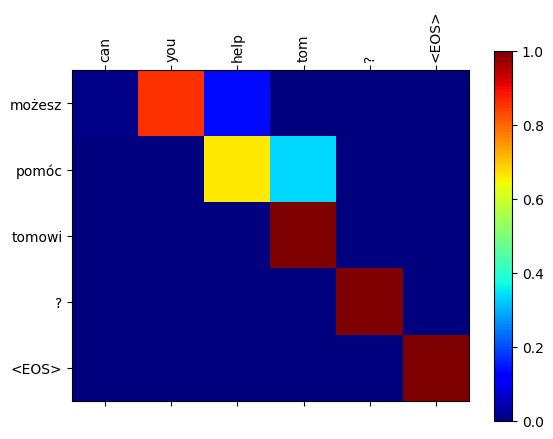

  9%|#2           | 4700/50000 [4:36:03<39:29:35,  3.14s/it]
276m 3s (- 2660m 39s) (4700 9%) 0.4622
> i don't know what i'm doing here .
= nie wiem , co tutaj robię .
< nie wiem , co robię tutaj . <EOS>


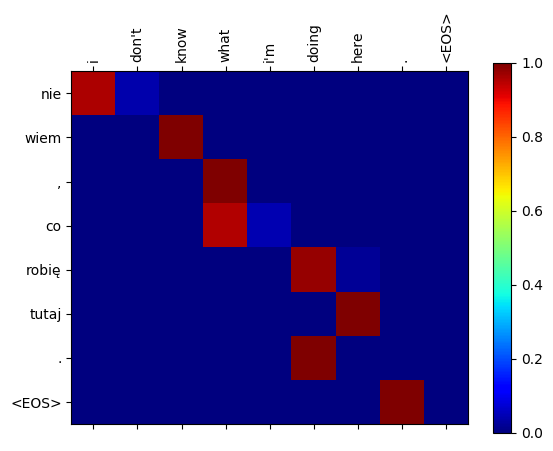

 10%|#2           | 4750/50000 [4:39:00<44:55:34,  3.57s/it]
279m 0s (- 2657m 57s) (4750 9%) 0.4231
> were you at home all morning ?
= byłeś cały poranek w domu ?
< byłeś w domu cały ranek ? <EOS>


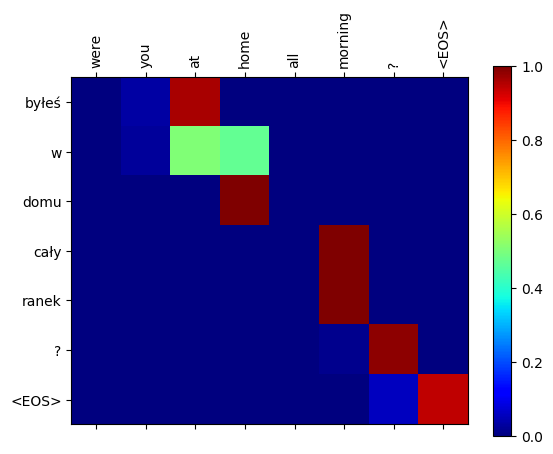

 10%|#2           | 4800/50000 [4:41:55<38:23:07,  3.06s/it]
281m 55s (- 2654m 46s) (4800 9%) 0.4292
> a lot of people are killed in automobile accidents every year .
= mnóstwo ludzi ginie co roku w wypadkach samochodowych .
< wielu ludzi ginie co roku w wypadkach samochodowych . <EOS>


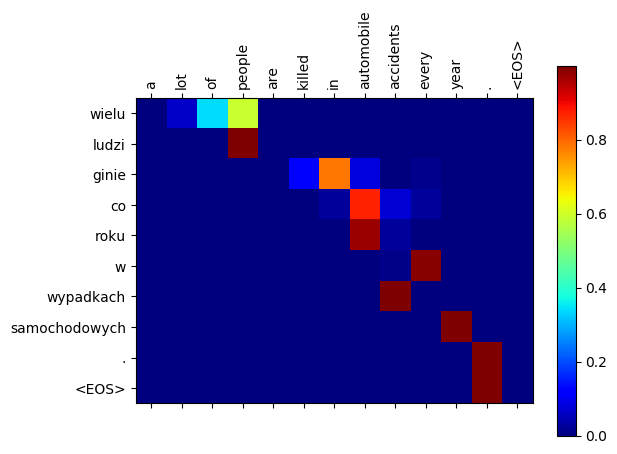

 10%|#2           | 4850/50000 [4:45:00<36:59:12,  2.95s/it]
285m 0s (- 2653m 13s) (4850 9%) 0.4059
> i made a bet that she would win the game .
= założyłem się , że ona wygra tę grę .
< założyłem się , że ona wygra tę grę . <EOS>


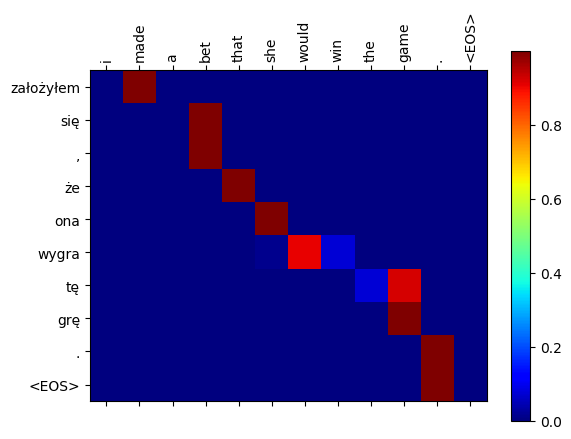

 10%|#2           | 4900/50000 [4:47:48<48:17:51,  3.86s/it]
287m 48s (- 2649m 3s) (4900 9%) 0.4209
> tom is starting to lose it .
= tom zaczyna tracić nad sobą panowanie .
< tom zaczyna tracić nad sobą panowanie . <EOS>


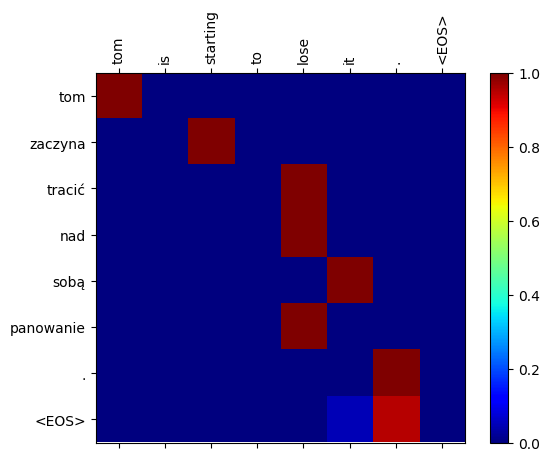

 10%|#2           | 4950/50000 [4:50:42<43:37:57,  3.49s/it]
290m 42s (- 2645m 48s) (4950 9%) 0.4152
> tom always thinks he's right .
= tom zawsze uważa , że ma rację .
< tom zawsze uważa , że ma rację . <EOS>


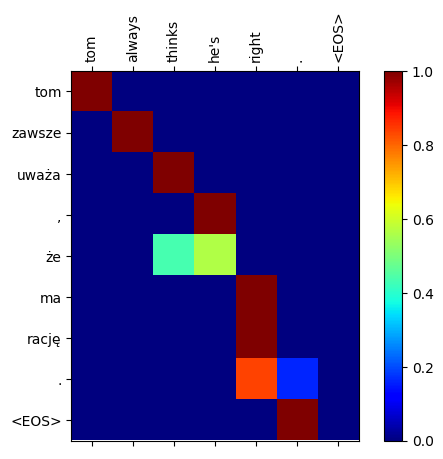

 10%|#3           | 5000/50000 [4:53:48<59:04:22,  4.73s/it]
293m 48s (- 2644m 20s) (5000 10%) 0.3990
> everybody's looking for you .
= wszyscy cię szukają .
< wszyscy cię szukają . <EOS>


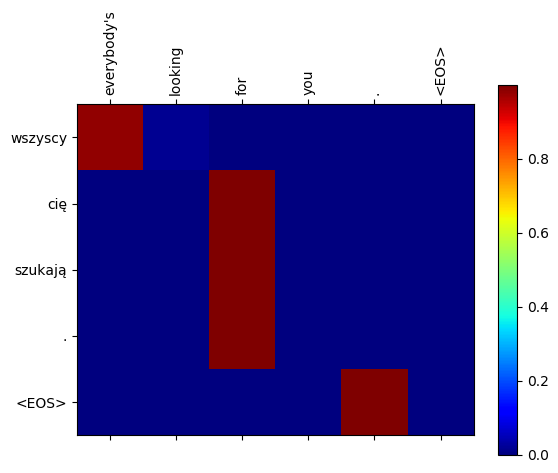

 10%|#3           | 5050/50000 [4:56:36<50:09:08,  4.02s/it]
296m 36s (- 2640m 6s) (5050 10%) 0.4056
> is there anything else we can do ?
= czy możemy coś jeszcze zrobić ?
< czy jest coś jeszcze , co możemy zrobić ? <EOS>


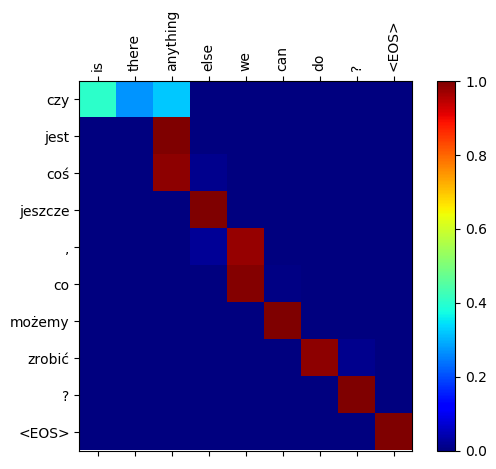

 10%|#3           | 5100/50000 [4:59:31<45:18:10,  3.63s/it]
299m 31s (- 2636m 55s) (5100 10%) 0.3764
> the hat costs less than the coat .
= kapelusz kosztuje mniej niż płaszcz .
< kapelusz kosztuje mniej niż płaszcz . <EOS>


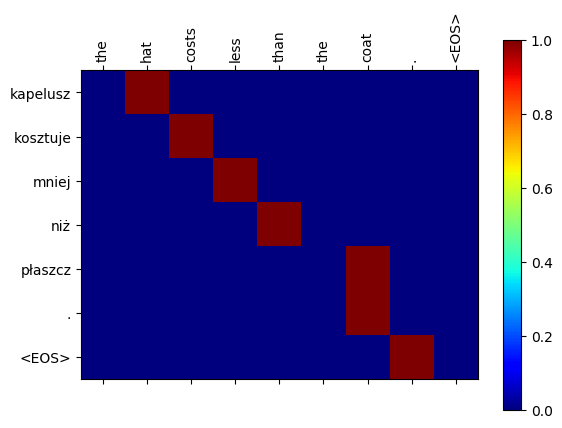

 10%|#3           | 5150/50000 [5:02:09<39:39:14,  3.18s/it]
302m 9s (- 2631m 22s) (5150 10%) 0.3671
> do you remember ?
= pamiętasz ?
< pamiętasz ? <EOS>


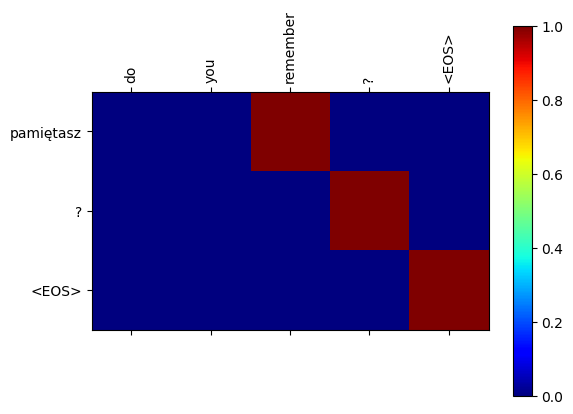

 10%|#3           | 5200/50000 [5:04:50<38:59:27,  3.13s/it]
304m 50s (- 2626m 20s) (5200 10%) 0.3839
> i knew it would happen .
= wiedziałam , że tak będzie .
< wiedziałem , że to się stanie . <EOS>


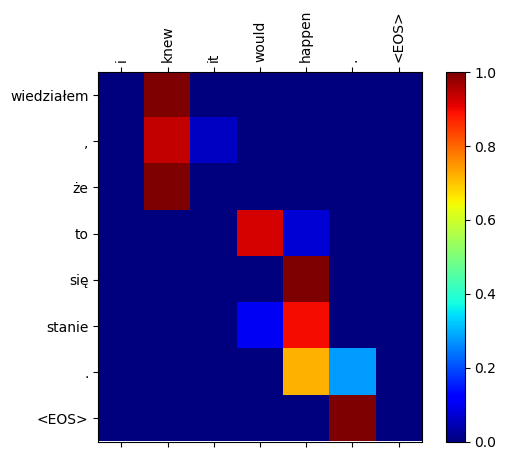

 10%|#3           | 5250/50000 [5:07:46<44:31:53,  3.58s/it]
307m 46s (- 2623m 21s) (5250 10%) 0.3745
> i have many friends here .
= mam tu wielu przyjaciół .
< mam tu wielu przyjaciół . <EOS>


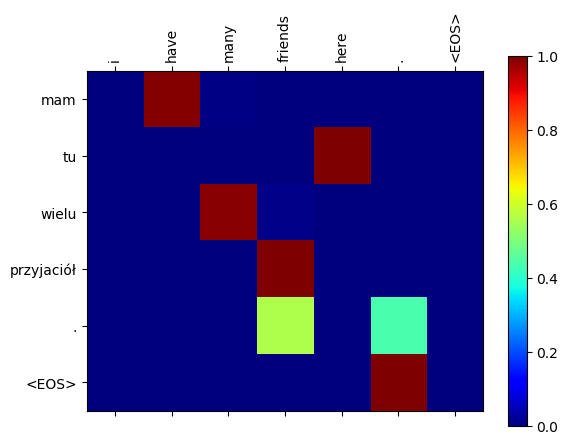

 11%|#3           | 5300/50000 [5:10:35<33:12:11,  2.67s/it]
310m 35s (- 2619m 30s) (5300 10%) 0.3640
> my parents were furious .
= moi rodzice byli wściekli .
< moi rodzice byli wściekli . <EOS>


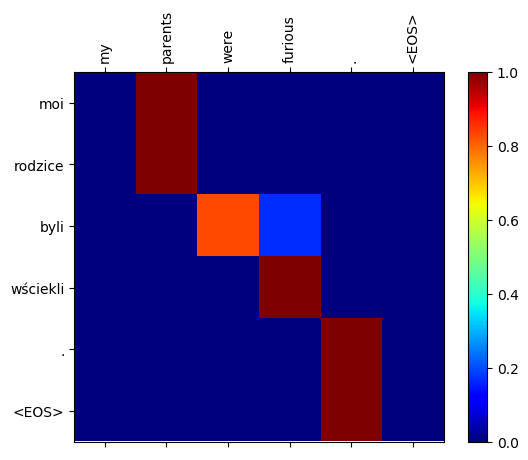

 11%|#3           | 5350/50000 [5:13:37<39:49:42,  3.21s/it]
313m 37s (- 2617m 28s) (5350 10%) 0.3819
> tom likes this .
= tom to lubi .
< tomowi podoba się to . <EOS>


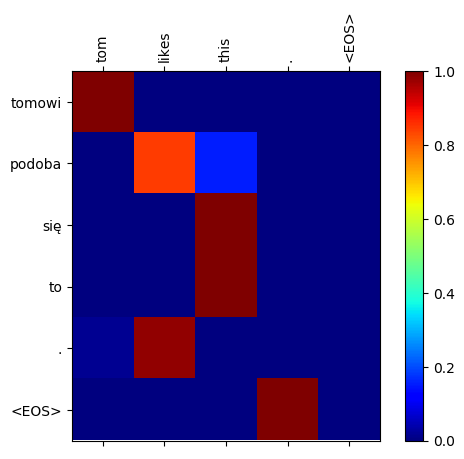

 11%|#4           | 5400/50000 [5:16:29<44:29:25,  3.59s/it]
316m 29s (- 2613m 57s) (5400 10%) 0.3331
> how come you know english so well ?
= jak to się stało , że tak dobrze znasz angielski ?
< skąd znasz angielskiego tak dobrze ? <EOS>


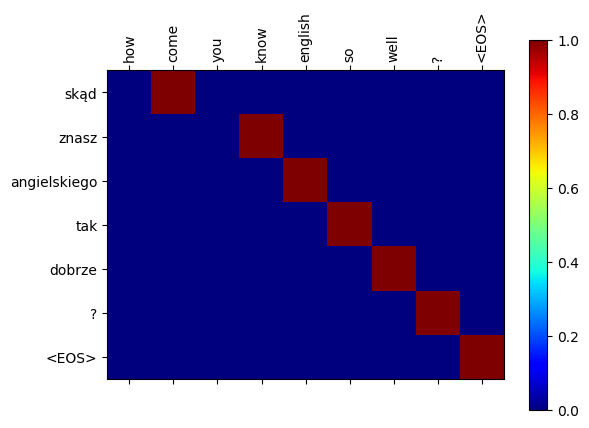

 11%|#4           | 5450/50000 [5:19:22<43:10:11,  3.49s/it]
319m 22s (- 2610m 43s) (5450 10%) 0.3360
> it'll soon be too dark to see .
= wkrótce będzie za ciemno , aby cokolwiek zobaczyć .
< wkrótce będzie za ciemno , żeby cokolwiek zobaczyć . <EOS>


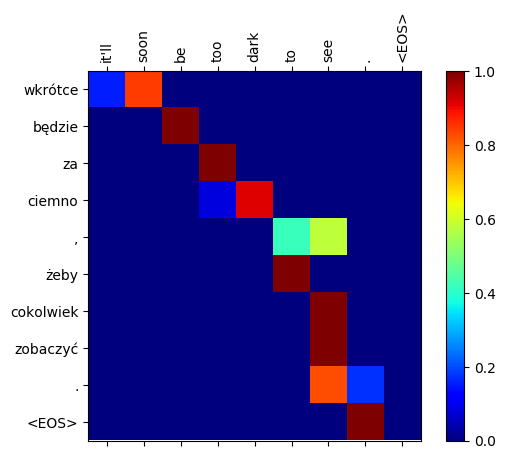

 11%|#4           | 5500/50000 [5:22:25<53:28:48,  4.33s/it]
322m 25s (- 2608m 41s) (5500 11%) 0.3336
> i like rock music .
= lubię muzykę rockową .
< lubię muzykę rockową . <EOS>


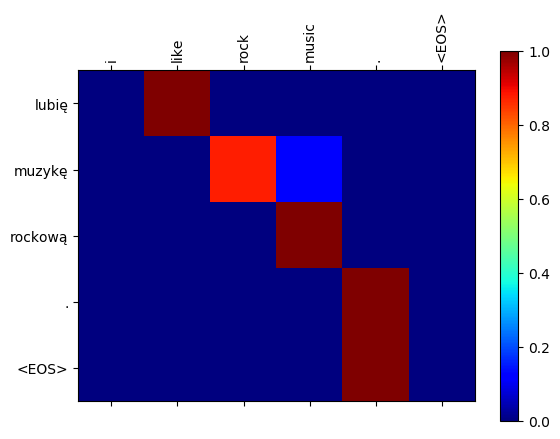

 11%|#4           | 5550/50000 [5:25:21<48:41:59,  3.94s/it]
325m 21s (- 2605m 50s) (5550 11%) 0.3327
> what's in the box ?
= co jest w pudełku ?
< co jest w pudełku ? <EOS>


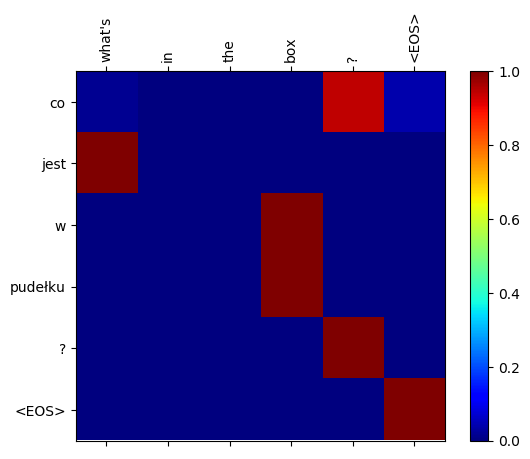

 11%|#4           | 5600/50000 [5:28:24<37:58:36,  3.08s/it]
328m 24s (- 2603m 52s) (5600 11%) 0.3302
> it is next to impossible for you to finish the work in a day .
= to jest praktycznie niemożliwe , abyś skończył tą pracę w jeden dzień .
< to jest praktycznie niemożliwe , abyś skończył tą pracę w jeden dzień . <EOS>


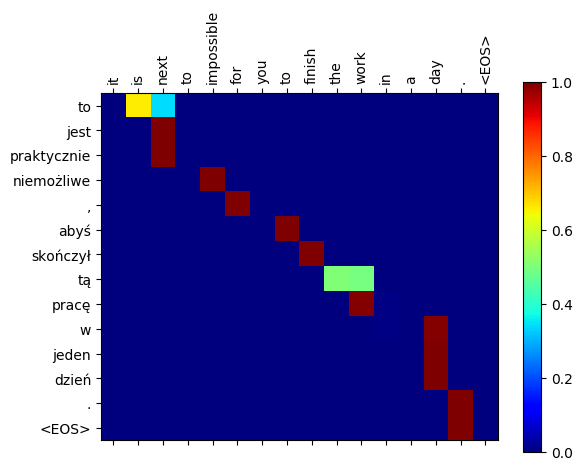

 11%|#4           | 5650/50000 [5:31:28<41:22:55,  3.36s/it]
331m 28s (- 2601m 55s) (5650 11%) 0.3281
> the door is sometimes open .
= drzwi są czasami otwarte .
< drzwi są martwi . <EOS>


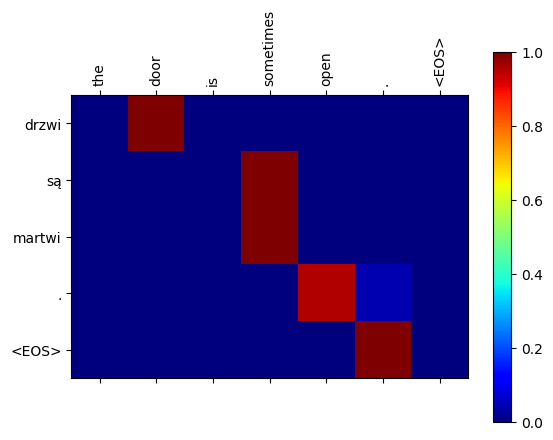

 11%|#4           | 5700/50000 [5:34:32<39:24:01,  3.20s/it]
334m 32s (- 2600m 0s) (5700 11%) 0.3186
> tom is your brother , isn't he ?
= tom to twój brat , prawda ?
< tom jest twój brat , prawda ? <EOS>


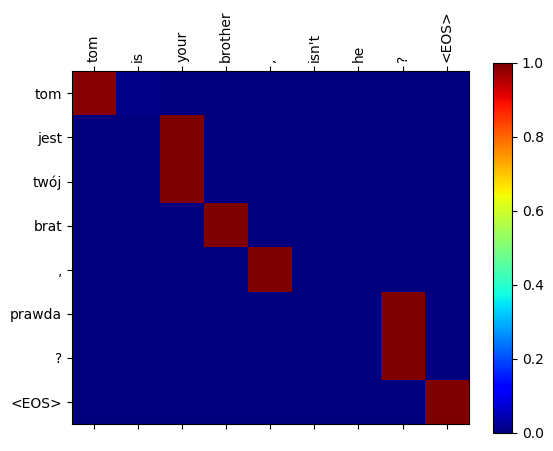

 12%|#4           | 5750/50000 [5:37:30<47:00:41,  3.82s/it]
337m 30s (- 2597m 18s) (5750 11%) 0.3078
> i can't translate this sentence .
= nie potrafię przetłumaczyć tego zdania .
< nie potrafię przetłumaczyć tego zdania . <EOS>


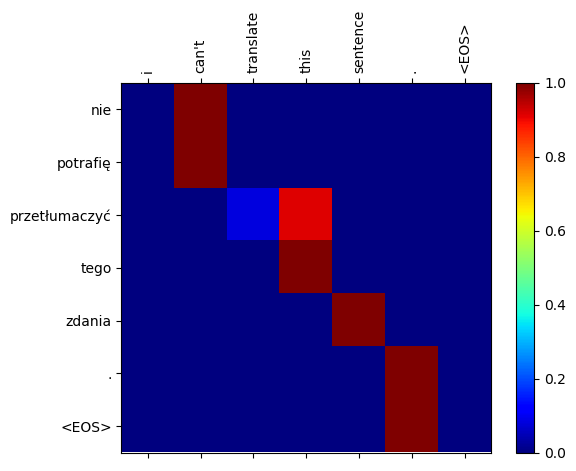

 12%|#5           | 5800/50000 [5:40:20<39:00:44,  3.18s/it]
340m 20s (- 2593m 38s) (5800 11%) 0.3167
> i'm sure they can hear us .
= jestem pewien , że oni nas słyszą .
< jestem pewien , że oni nas słyszą . <EOS>


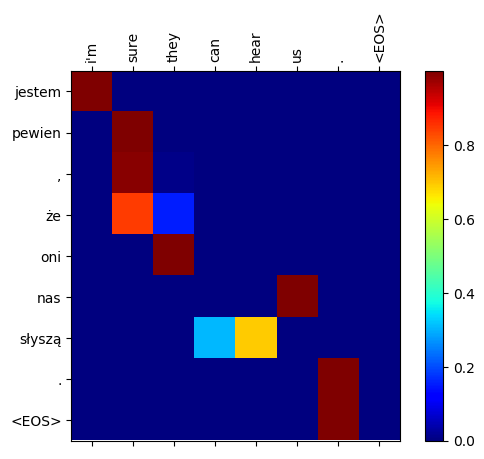

 12%|#5           | 5850/50000 [5:43:29<44:34:06,  3.63s/it]
343m 29s (- 2592m 16s) (5850 11%) 0.2949
> has he arrived yet ?
= czy on już przyjechał ?
< czy on już przybył ? <EOS>


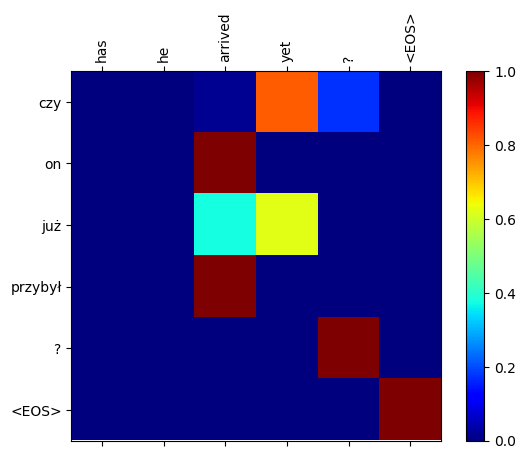

 12%|#5           | 5900/50000 [5:46:20<42:45:49,  3.49s/it]
346m 20s (- 2588m 47s) (5900 11%) 0.2938
> he is in the prime of life .
= on jest w kwiecie wieku .
< jest w kwiecie wieku . <EOS>


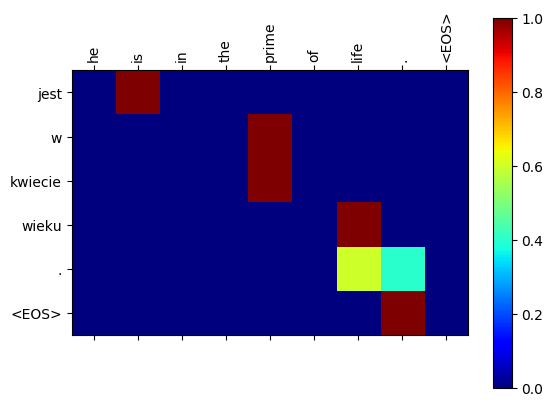

 12%|#5           | 5950/50000 [5:49:12<38:49:18,  3.17s/it]
349m 12s (- 2585m 16s) (5950 11%) 0.2882
> get tom away from here .
= zabierz stąd toma .
< zabierz toma stąd . <EOS>


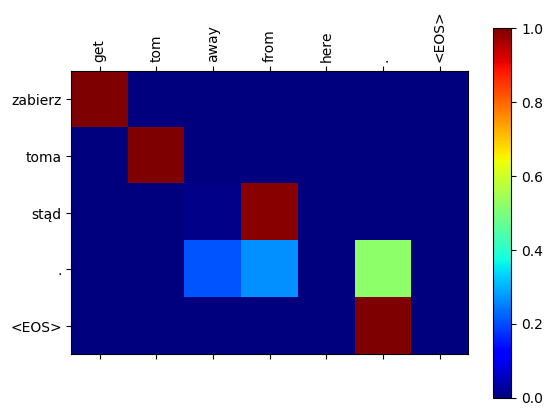

 12%|#5           | 6000/50000 [5:52:04<38:01:10,  3.11s/it]
352m 4s (- 2581m 54s) (6000 12%) 0.2811
> i still don't understand this .
= nadal tego nie rozumiem .
< nadal tego nie rozumiem . <EOS>


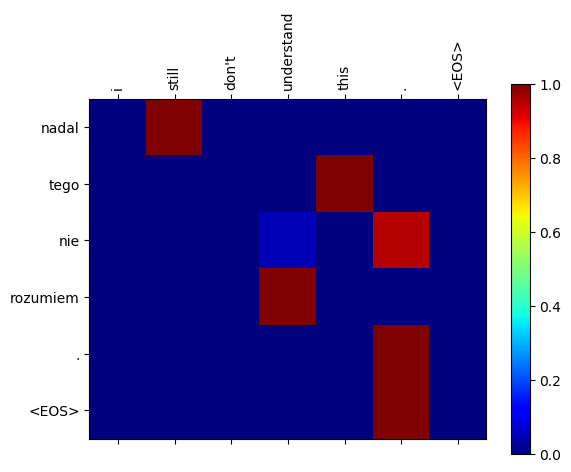

 12%|#5           | 6050/50000 [5:55:02<44:53:54,  3.68s/it]
355m 2s (- 2579m 8s) (6050 12%) 0.2836
> how long have you known about this ?
= od jak dawna o tym wiesz ?
< od jak dawna o tym wiesz ? <EOS>


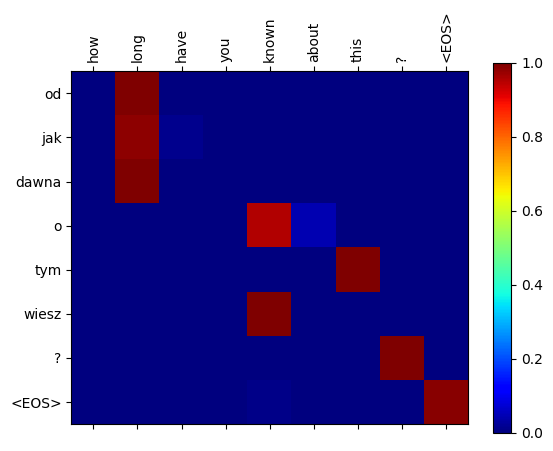

 12%|#5           | 6100/50000 [5:57:49<41:13:11,  3.38s/it]
357m 49s (- 2575m 11s) (6100 12%) 0.2737
> let's get out of this place .
= zmywajmy się stąd .
< chodźmy z tym miejscu . <EOS>


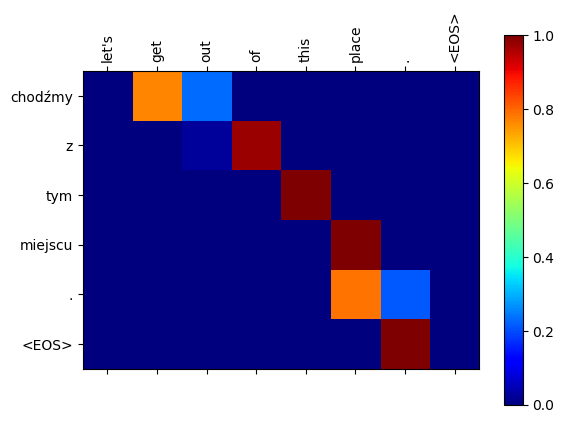

 12%|#5           | 6150/50000 [6:00:50<47:05:20,  3.87s/it]
360m 50s (- 2572m 52s) (6150 12%) 0.2774
> mary kept on working in spite of her illness .
= mary kontynuowała pracę , pomimo swojej choroby .
< mary kontynuowała pracę , pomimo swojej choroby . <EOS>


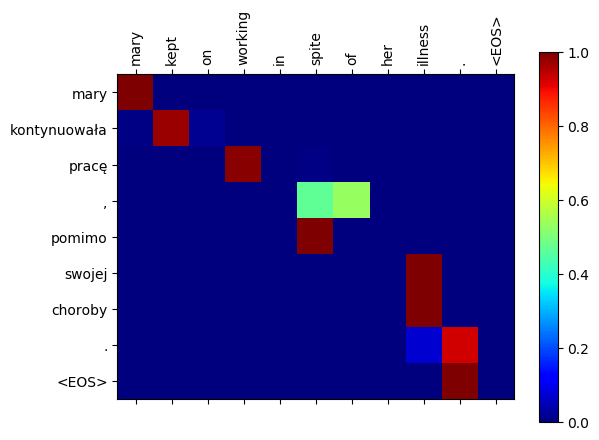

 12%|#6           | 6200/50000 [6:03:53<42:08:45,  3.46s/it]
363m 53s (- 2570m 44s) (6200 12%) 0.2673
> please give me your attention .
= proszę o uwagę .
< poproszę o uwagę . <EOS>


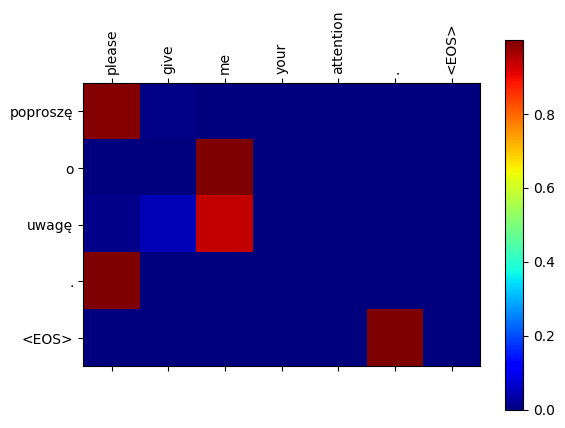

 12%|#6           | 6250/50000 [6:06:50<43:56:21,  3.62s/it]
366m 50s (- 2567m 53s) (6250 12%) 0.2655
> this is a film that everybody should see .
= to jest film który każdy powinien obejrzeć .
< to jest film przed każdym zachowaniem . <EOS>


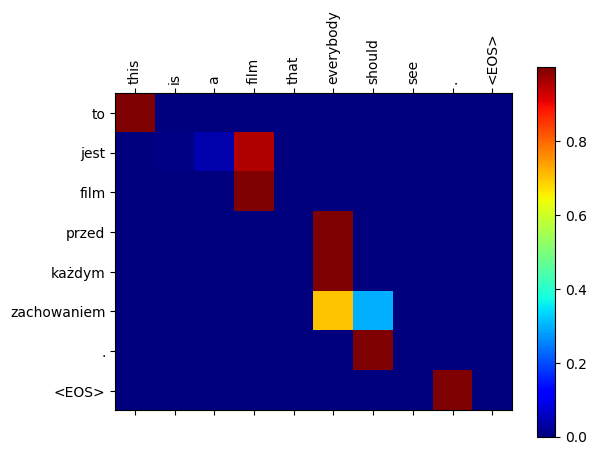

 13%|#6           | 6300/50000 [6:09:45<38:06:32,  3.14s/it]
369m 45s (- 2564m 48s) (6300 12%) 0.2551
> he is precisely the man we're looking for .
= on jest dokładnie człowiekiem , którego szukamy .
< jest jedynym człowiekiem od toma . <EOS>


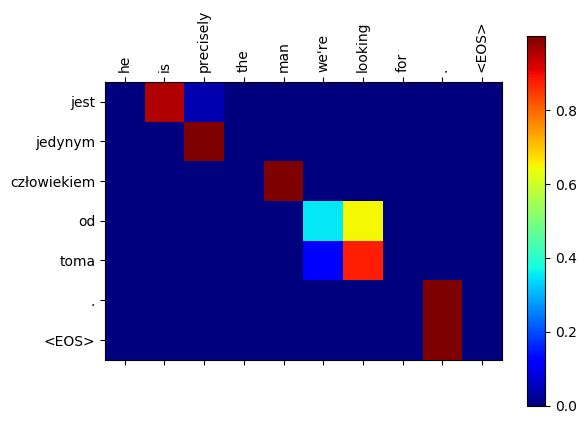

 13%|#6           | 6350/50000 [6:12:37<41:15:46,  3.40s/it]
372m 37s (- 2561m 25s) (6350 12%) 0.2562
> what is your name , sir ?
= jak się pan nazywa ?
< jak się pan nazywa , prawda ? <EOS>


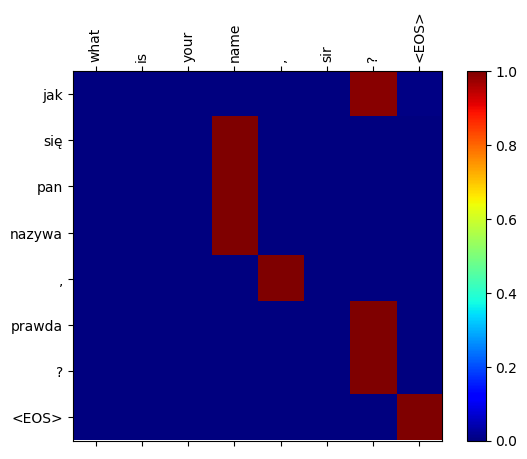

 13%|#6           | 6400/50000 [6:15:30<44:01:12,  3.63s/it]
375m 30s (- 2558m 7s) (6400 12%) 0.2500
> i bet you didn't know that .
= założę się , że tego nie wiedziałaś .
< założę się , że tego nie wiedziałeś . <EOS>


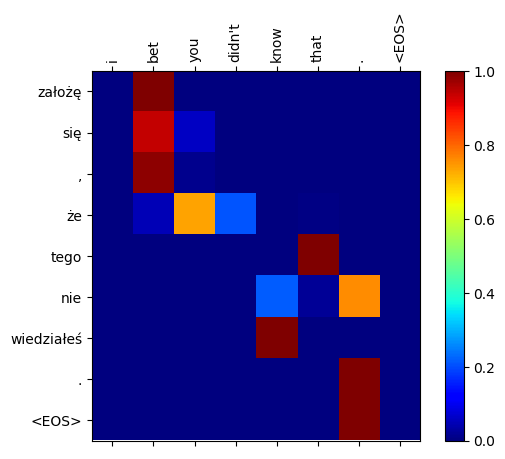

 13%|#6           | 6450/50000 [6:18:16<40:43:32,  3.37s/it]
378m 16s (- 2554m 7s) (6450 12%) 0.2399
> tom and mary really hate each other .
= tom i mary naprawdę się wzajemnie nienawidzą .
< tom i mary naprawdę się wzajemnie nienawidzą . <EOS>


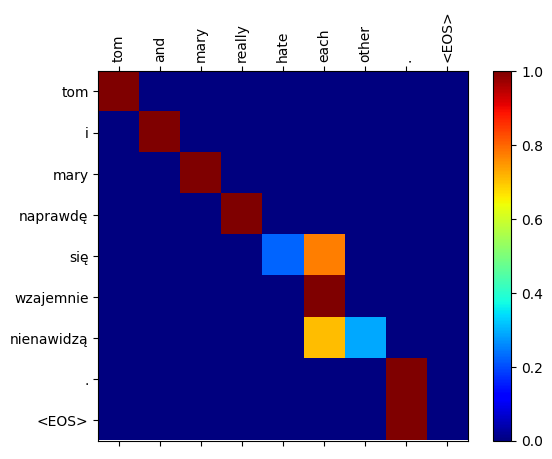

 13%|#6           | 6500/50000 [6:21:12<43:03:43,  3.56s/it]
381m 12s (- 2551m 7s) (6500 13%) 0.2495
> i try to walk at least a few kilometers every day .
= próbuję spacerować przynajmniej kilka kilometrów każdego dnia .
< próbuję spacerować przynajmniej kilka kilometrów każdego dnia . <EOS>


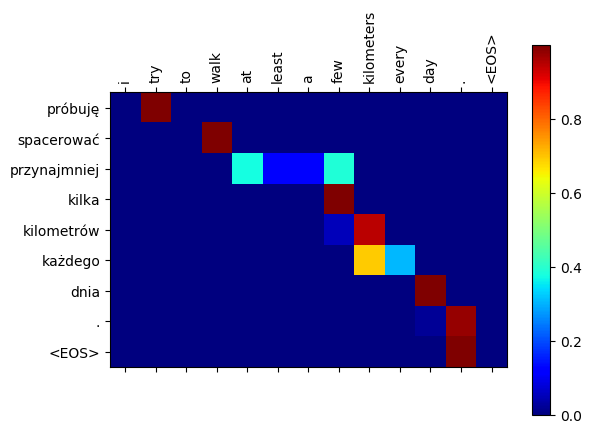

 13%|#7           | 6550/50000 [6:24:23<48:34:56,  4.03s/it]
384m 23s (- 2549m 53s) (6550 13%) 0.2498
> thanks to your help , we were successful .
= dzięki twojej pomocy udało się nam .
< dzięki twojej pomocy udało się nam . <EOS>


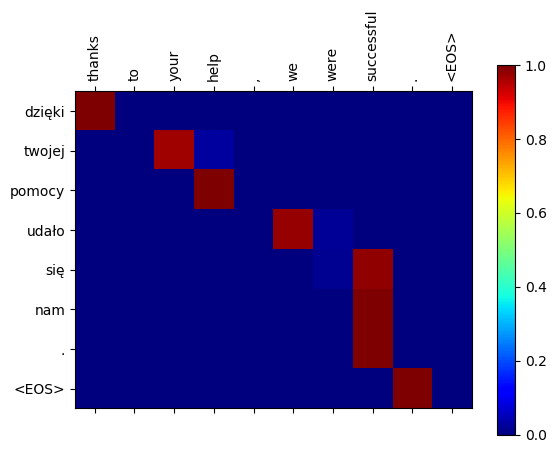

 13%|#7           | 6600/50000 [6:27:22<36:09:39,  3.00s/it]
387m 22s (- 2547m 16s) (6600 13%) 0.2453
> may i ask why ?
= mogę spytać dlaczego ?
< czy mogę spytać dlaczego ? <EOS>


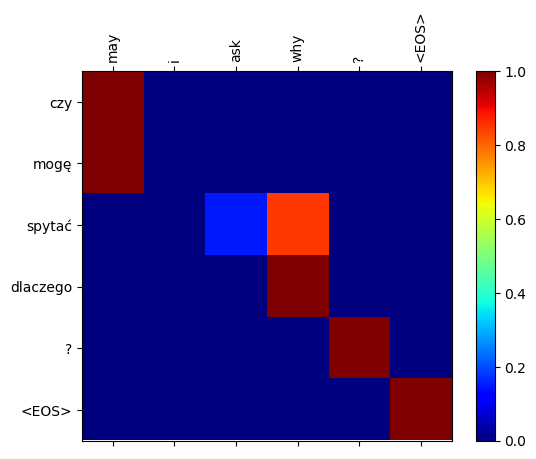

 13%|#7           | 6650/50000 [6:30:20<44:17:10,  3.68s/it]
390m 20s (- 2544m 33s) (6650 13%) 0.2342
> i've had no problems with my boss .
= nie miałem problemów z szefem .
< nie miałem problemów z szefem . <EOS>


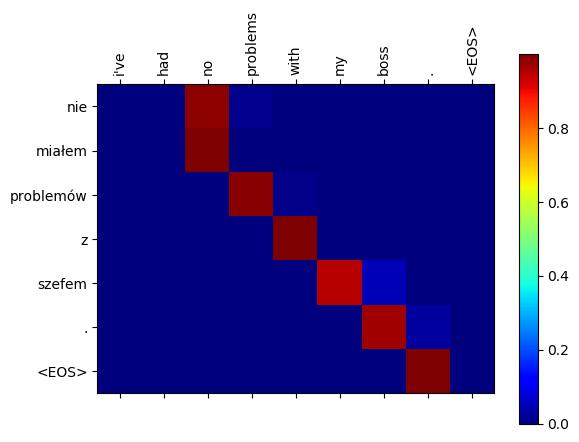

 13%|#7           | 6700/50000 [6:33:20<42:51:26,  3.56s/it]
393m 20s (- 2542m 4s) (6700 13%) 0.2295
> it's too big .
= to jest za duże .
< to jest za duże . <EOS>


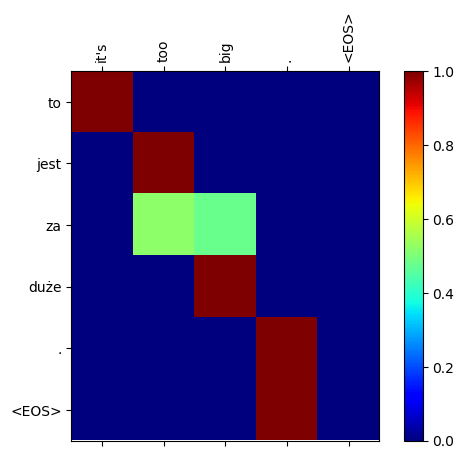

 14%|#7           | 6750/50000 [6:36:19<40:24:03,  3.36s/it]
396m 19s (- 2539m 22s) (6750 13%) 0.2286
> tom started playing rugby three years ago .
= tom zaczął grać w rugby trzy lata temu .
< tom zaczął grać w rugby trzy lata temu . <EOS>


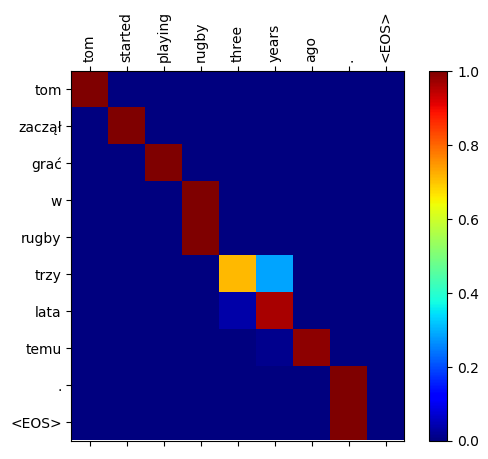

 14%|#7           | 6800/50000 [6:39:27<42:57:35,  3.58s/it]
399m 27s (- 2537m 43s) (6800 13%) 0.2274
> the building is twenty stories high .
= ten budynek ma 20 pięter .
< ten budynek ma 20 pięter . <EOS>


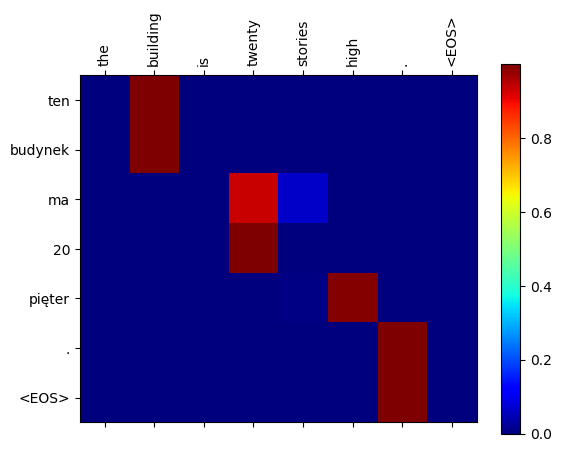

 14%|#7           | 6850/50000 [6:42:31<49:15:08,  4.11s/it]
402m 31s (- 2535m 39s) (6850 13%) 0.2227
> i've lied to you .
= okłamałem cię .
< okłamałem cię . <EOS>


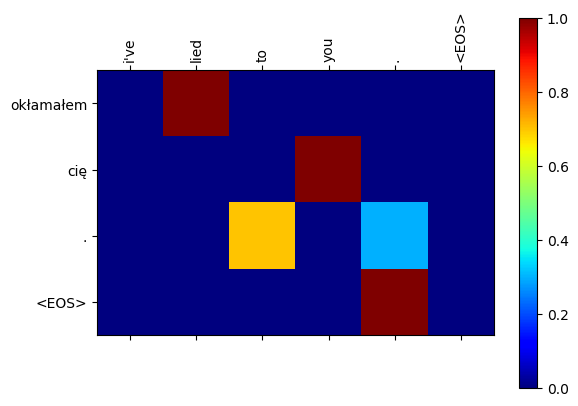

 14%|#7           | 6900/50000 [6:45:27<43:39:55,  3.65s/it]
405m 27s (- 2532m 40s) (6900 13%) 0.2144
> i'll be very careful .
= będę bardzo ostrożny .
< będę bardzo ostrożny . <EOS>


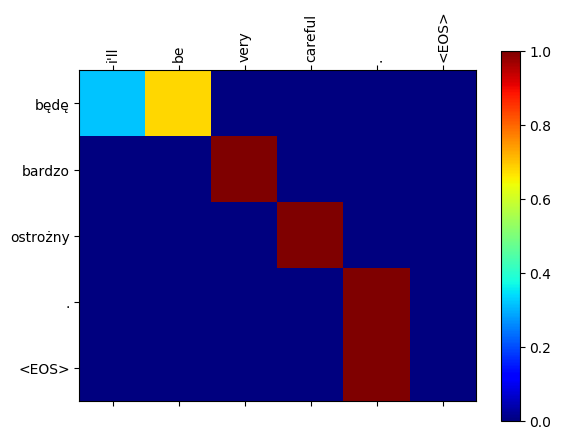

 14%|#8           | 6950/50000 [6:48:17<45:23:22,  3.80s/it]
408m 17s (- 2529m 2s) (6950 13%) 0.2126
> where is your money ?
= gdzie są twoje pieniądze ?
< gdzie są twoje pieniądze ? <EOS>


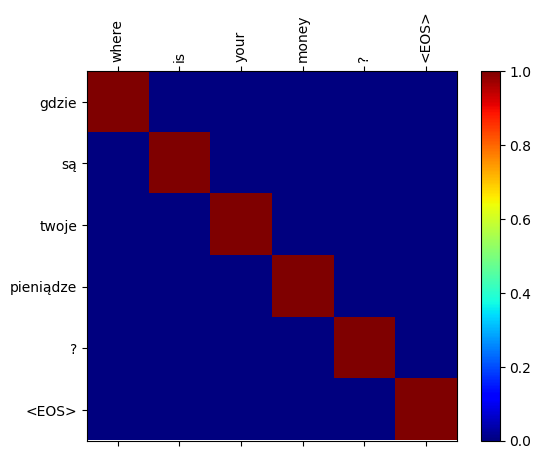

 14%|#8           | 7000/50000 [6:51:12<44:06:41,  3.69s/it]
411m 12s (- 2525m 58s) (7000 14%) 0.2084
> you may stay here as long as you like .
= możesz tu zostać tak długo , jak chcesz .
< możesz tu zostać długo , jak chcesz . <EOS>


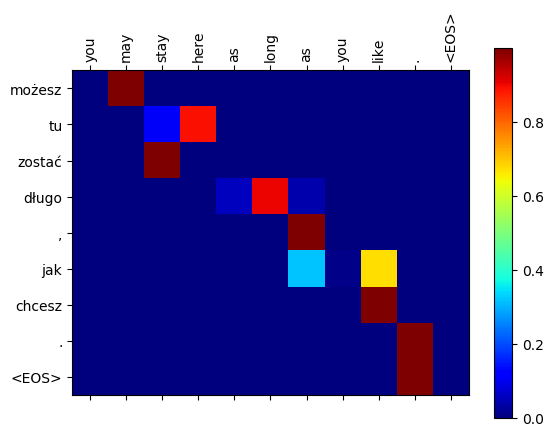

 14%|#8           | 7050/50000 [6:54:03<39:06:16,  3.28s/it]
414m 3s (- 2522m 31s) (7050 14%) 0.2117
> now you're safe .
= teraz jesteś bezpieczny .
< teraz jesteś bezpieczny . <EOS>


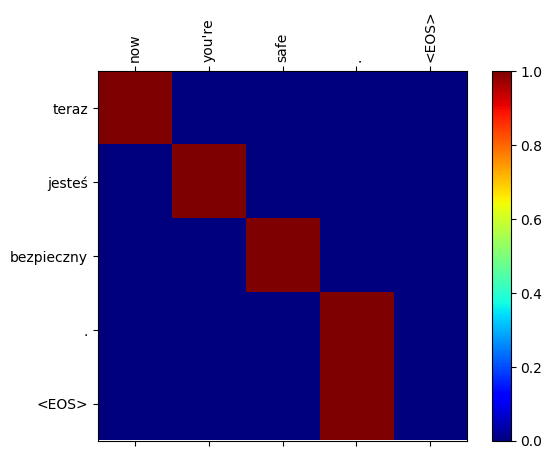

 14%|#8           | 7100/50000 [6:57:06<37:39:52,  3.16s/it]
417m 6s (- 2520m 17s) (7100 14%) 0.2101
> we understand .
= rozumiemy .
< rozumiemy . <EOS>


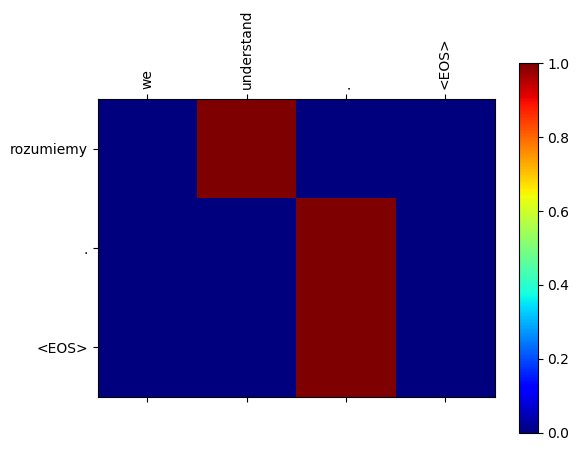

 14%|#8           | 7150/50000 [6:59:58<48:58:56,  4.12s/it]
419m 58s (- 2516m 56s) (7150 14%) 0.2006
> what kind of gift do you want ?
= jaki chcesz prezent ?
< co cię prezent ? <EOS>


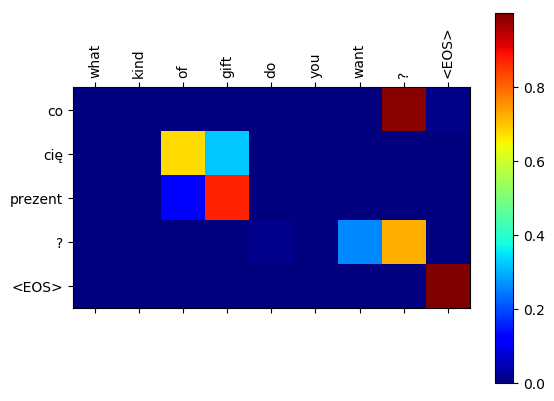

 14%|#8           | 7200/50000 [7:02:55<38:31:05,  3.24s/it]
422m 55s (- 2514m 0s) (7200 14%) 0.2071
> there are pretty flowers in the garden .
= w ogrodzie są piękne kwiaty .
< w ogrodzie są piękne kwiaty . <EOS>


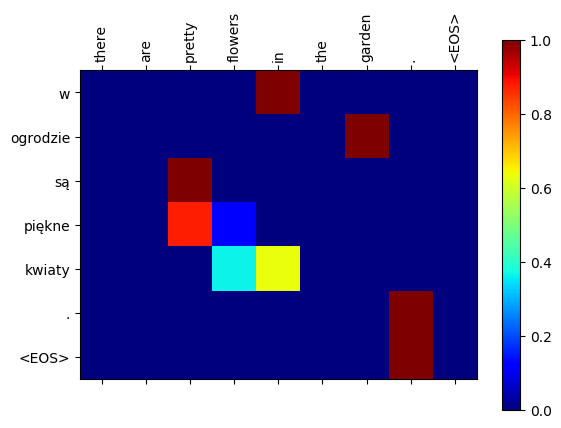

 14%|#8           | 7250/50000 [7:05:42<38:29:05,  3.24s/it]
425m 42s (- 2510m 14s) (7250 14%) 0.1985
> right after i graduated from college , i went into the army .
= zaraz po skończeniu uczelni poszedłem do wojska .
< zaraz po skończeniu uczelni poszedłem do wojska . <EOS>


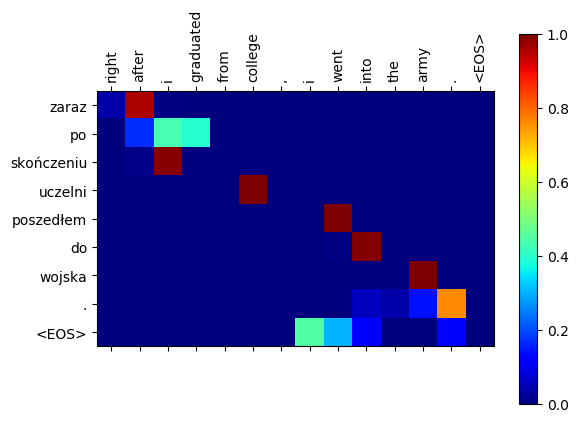

 15%|#8           | 7300/50000 [7:08:34<42:30:54,  3.58s/it]
428m 34s (- 2506m 50s) (7300 14%) 0.1971
> think about it .
= pomyśl o tym .
< pomyśl o tym . <EOS>


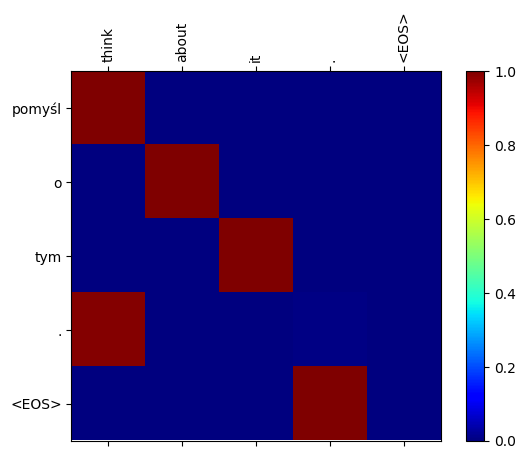

 15%|#9           | 7350/50000 [7:11:21<36:49:26,  3.11s/it]
431m 21s (- 2503m 2s) (7350 14%) 0.2031
> add a little milk .
= dodaj trochę mleka .
< dodaj trochę mleka . <EOS>


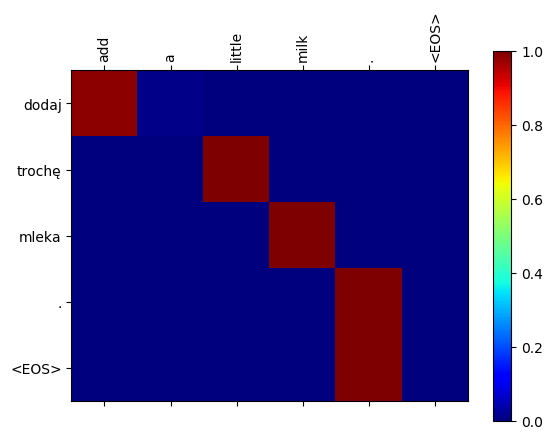

 15%|#9           | 7400/50000 [7:14:15<47:36:41,  4.02s/it]
434m 15s (- 2499m 54s) (7400 14%) 0.1977
> i'll do as you suggested .
= zrobię , jak zaproponowałeś .
< zrobię jak zaproponowałeś . <EOS>


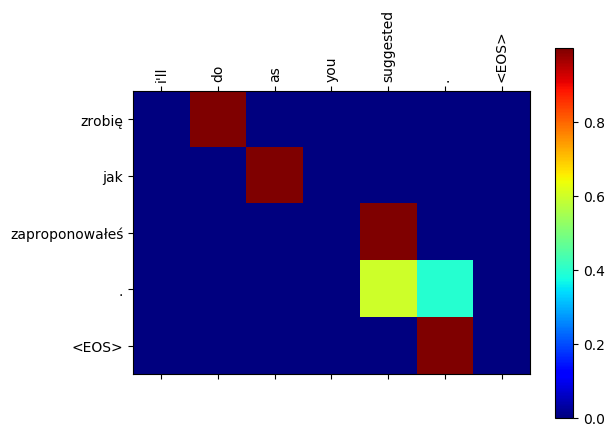

 15%|#9           | 7450/50000 [7:17:17<48:19:40,  4.09s/it]
437m 17s (- 2497m 34s) (7450 14%) 0.2021
> we feel safe .
= czujemy się bezpiecznie .
< czujemy się bezpiecznie . <EOS>


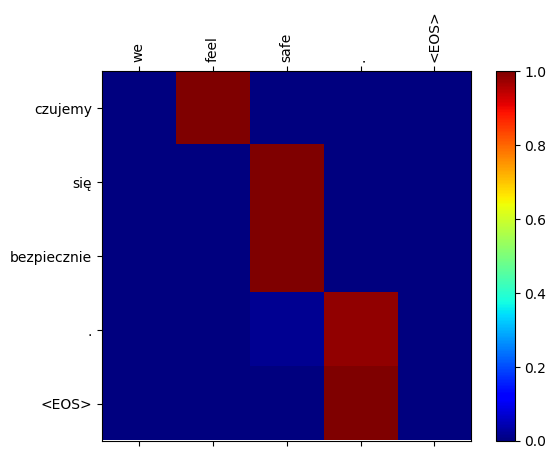

 15%|#9           | 7500/50000 [7:20:10<36:15:39,  3.07s/it]
440m 10s (- 2494m 20s) (7500 15%) 0.1863
> tom is wearing sunglasses .
= tom ma na sobie okulary przeciwsłoneczne .
< tom ma na sobie okulary . <EOS>


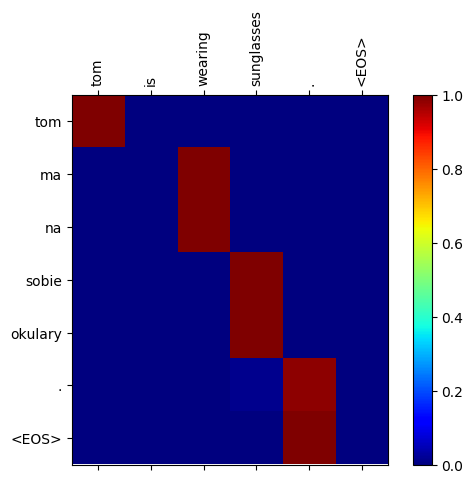

 15%|#9           | 7550/50000 [7:23:10<43:28:25,  3.69s/it]
443m 10s (- 2491m 44s) (7550 15%) 0.1873
> tom predicted his own death .
= tom przewidział swoją własną śmierć .
< tom przewidział swoją własną śmierć . <EOS>


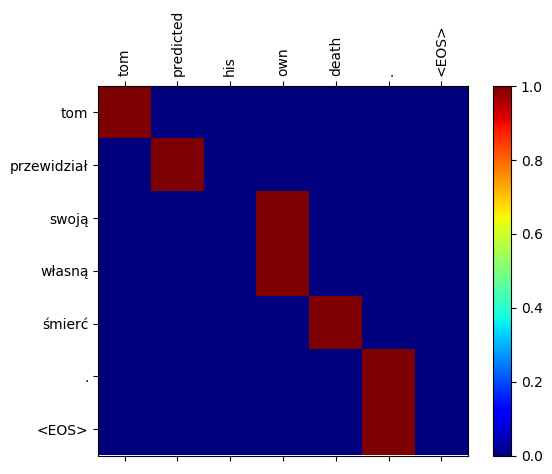

 15%|#9           | 7600/50000 [7:26:05<48:19:15,  4.10s/it]
446m 5s (- 2488m 43s) (7600 15%) 0.1891
> i told tom to do it .
= kazałem tomowi to zrobić .
< kazałem tomowi to zrobić . <EOS>


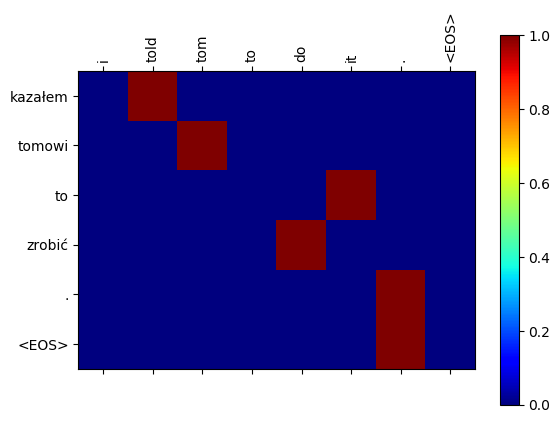

 15%|#9           | 7650/50000 [7:29:10<46:54:46,  3.99s/it]
449m 10s (- 2486m 39s) (7650 15%) 0.1840
> i'm done with my chores .
= skończyłem swoje obowiązki .
< skończyłem swoje obowiązki . <EOS>


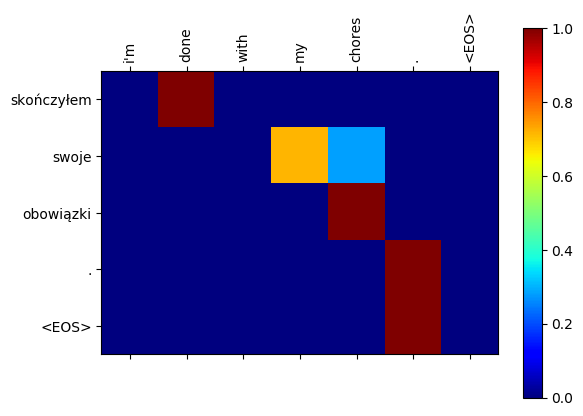

 15%|##           | 7700/50000 [7:31:54<37:07:02,  3.16s/it]
451m 54s (- 2482m 33s) (7700 15%) 0.1733
> tom tried to catch mary .
= tom próbował złapać marię .
< tom próbował złapać marię . <EOS>


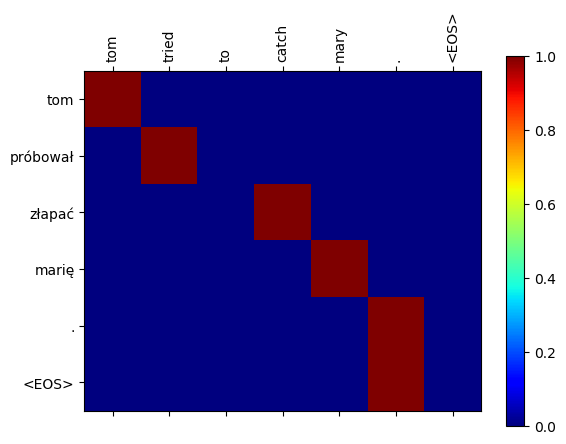

 16%|##           | 7750/50000 [7:34:58<50:36:31,  4.31s/it]
454m 58s (- 2480m 20s) (7750 15%) 0.1737
> i've never heard my mother sing a song .
= nigdy nie słyszałem , żeby moja mama śpiewała piosenkę .
< nigdy nie słyszałem , żeby moja mama śpiewała piosenkę . <EOS>


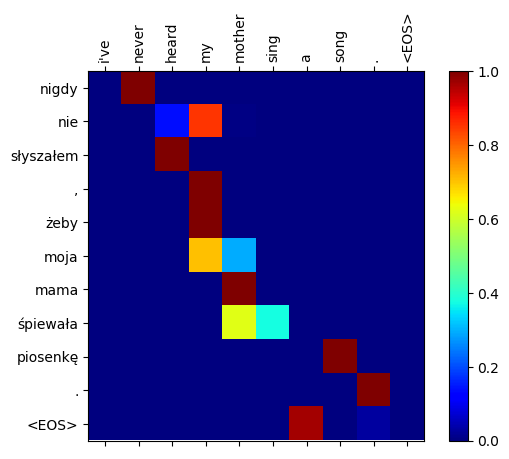

 16%|##           | 7800/50000 [7:37:50<42:40:25,  3.64s/it]
457m 50s (- 2477m 4s) (7800 15%) 0.1720
> he is fluent in chinese .
= mówi płynnie po chińsku .
< on mówi płynnie po chińsku . <EOS>


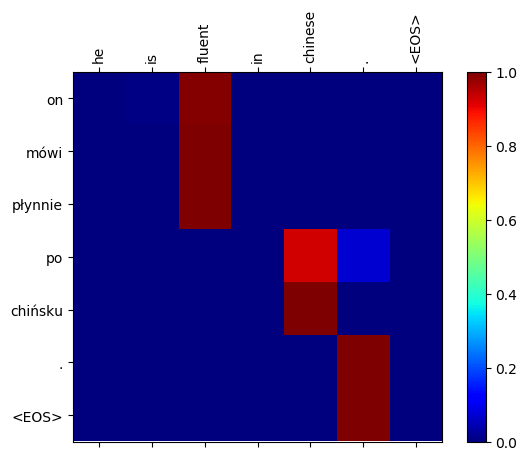

 16%|##           | 7850/50000 [7:40:37<39:35:39,  3.38s/it]
460m 37s (- 2473m 19s) (7850 15%) 0.1712
> i don't care about your past .
= twoja przeszłość mnie nie interesuje .
< twoja przeszłość mnie nie interesuje . <EOS>


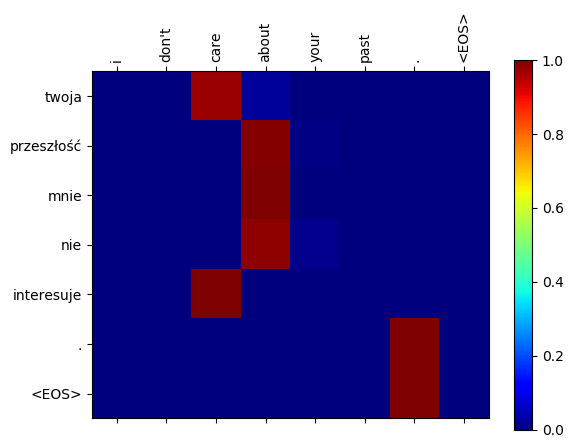

 16%|##           | 7900/50000 [7:43:44<50:49:39,  4.35s/it]
463m 44s (- 2471m 17s) (7900 15%) 0.1763
> she went to paris to study music .
= pojechała do paryża studiować muzykę .
< pojechała do paryża uczyć się muzyki . <EOS>


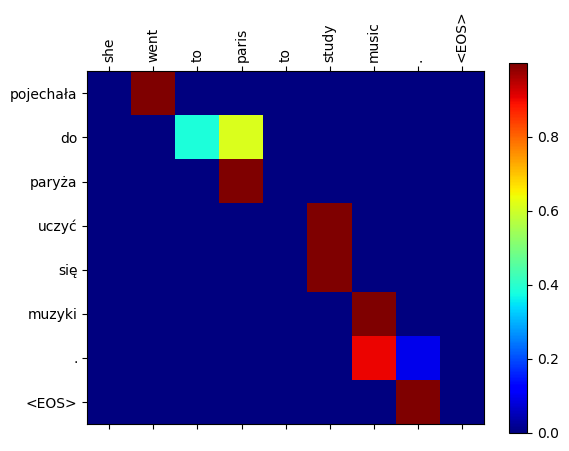

 16%|##           | 7950/50000 [7:46:44<48:24:15,  4.14s/it]
466m 44s (- 2468m 45s) (7950 15%) 0.1685
> i'd rather not know .
= wolę nie wiedzieć .
< wolę nie wiedzieć . <EOS>


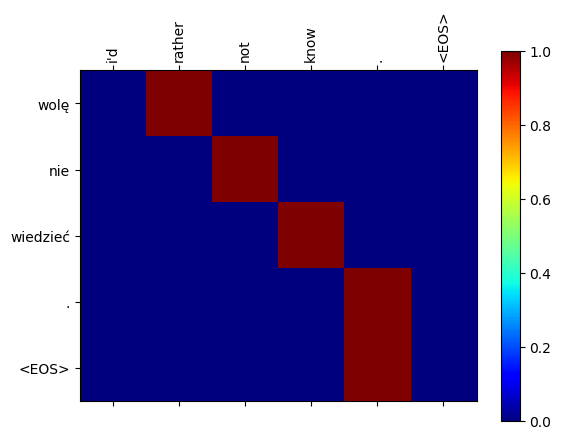

 16%|##           | 8000/50000 [7:49:49<37:52:47,  3.25s/it]
469m 49s (- 2466m 33s) (8000 16%) 0.1623
> tell me the rest .
= opowiedz mi resztę .
< powiedz mi resztę . <EOS>


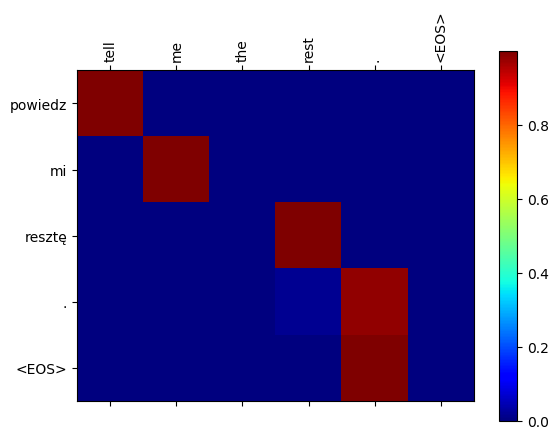

 16%|##           | 8050/50000 [7:52:46<43:55:27,  3.77s/it]
472m 46s (- 2463m 43s) (8050 16%) 0.1645
> he doesn't watch television at all .
= w ogóle nie ogląda telewizji .
< w ogóle nie ogląda telewizji . <EOS>


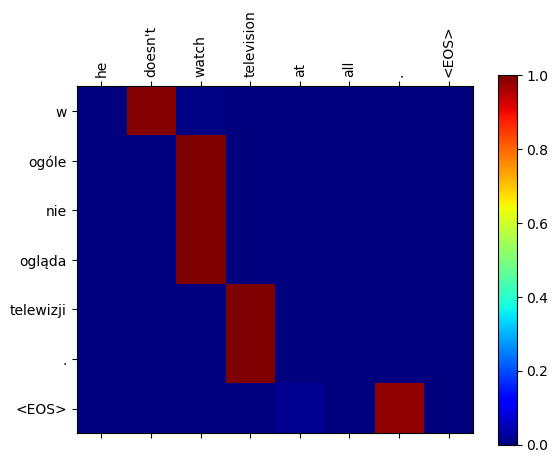

KeyboardInterrupt: 

In [33]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)

    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc
    
    job.record(epoch, loss)
    job.update_progress()

    if epoch % print_every == 0:
        print(f'{job.pbar}')
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
        vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
        vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0

## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

<Figure size 640x480 with 0 Axes>

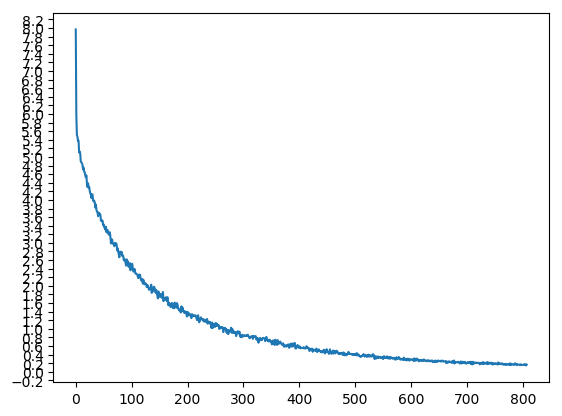

In [34]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [35]:
xxx=[print(random.choice(pairs)) for i in range(10)]

["i'm thirsty .", 'jestem spragniony .']
['are you nuts ?', 'zwariowałeś ?']
["i didn't know you had a brother .", 'nie wiedziałam , że masz brata .']
['if today was sunday , i would go fishing .', 'gdyby dziś była niedziela , poszedłbym na ryby .']
["i've known tom a long time .", 'znam toma od dawna .']
["tom's a great journalist .", 'tom jest świetnym dziennikarzem .']
["i'd like to go to boston again someday .", 'chciałbym kiedyś znowu pojechać do bostonu .']
["you don't need to be here .", 'nie musisz tu być .']
['my father went fishing .', 'mój ojciec poszedł łowić ryby .']
['it is already dark .', 'jest już ciemno .']


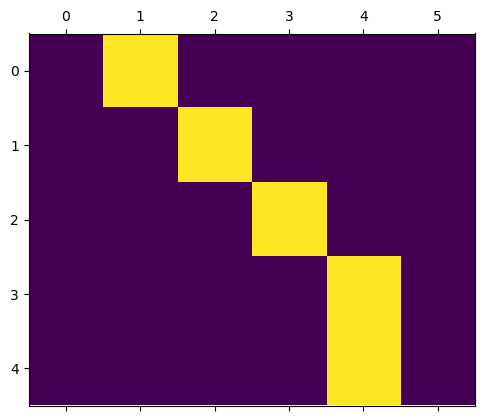

In [36]:
output_words, attentions = evaluate("it's time for lunch .")
plt.matshow(attentions.numpy())
show_plot_visdom()

['i failed after all .', 'nie udało mi się jednak .']
['i like you very much .', 'bardzo cię lubię .']
["i can't leave .", 'nie mogę wyjść .']
['i feel very good .', 'czuję się bardzo dobrze .']
["we've been here an hour .", 'jesteśmy tutaj godzinę .']
["i don't like it .", 'nie lubię tego .']
['tom likes boston .', 'tom lubi boston .']
['that works .', 'to działa .']
['i will try it again .', 'spróbuję ponownie .']
['tom drank some beer .', 'tom wypił piwo .']

> i failed after all .
= nie udało mi się jednak .
< ostatecznie mi nie wyszło . <EOS>


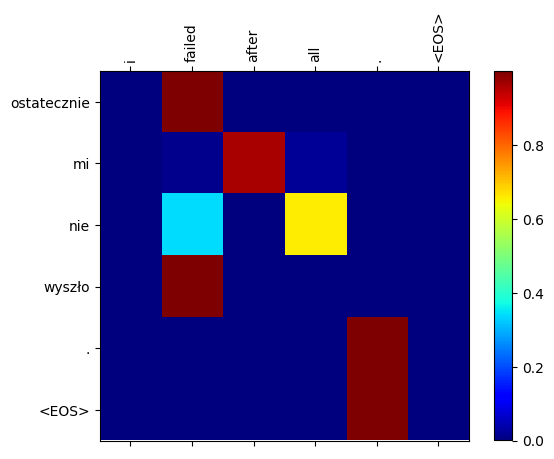

In [37]:
evaluate_and_show_attention('i failed after all .', 'nie udało mi się jednak .')

> i like you very much .
= bardzo cię lubię .
< bardzo cię lubię . <EOS>


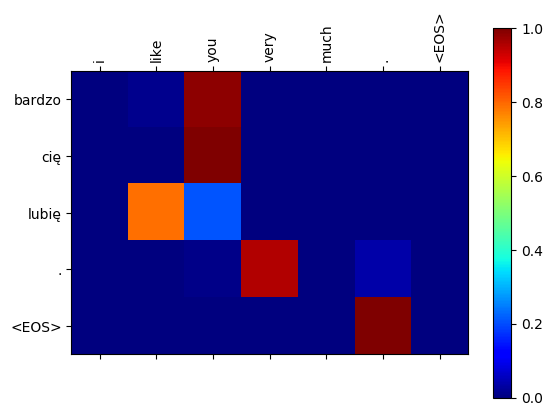

In [38]:
evaluate_and_show_attention('i like you very much .', 'bardzo cię lubię .')

> i can't leave .
= nie mogę wyjść .
< nie mogę wyjść . <EOS>


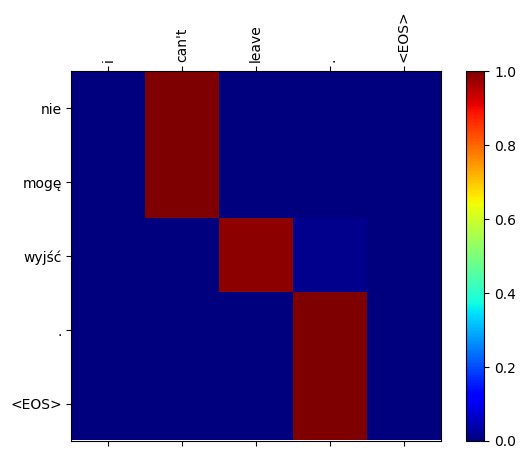

In [39]:
evaluate_and_show_attention("i can't leave .", 'nie mogę wyjść .')

> i feel very good .
= czuję się bardzo dobrze .
< czuję się bardzo dobrze . <EOS>


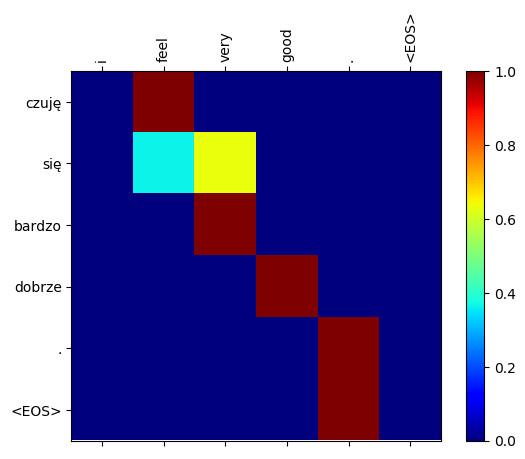

In [40]:
evaluate_and_show_attention('i feel very good .', 'czuję się bardzo dobrze .')

> we've been here an hour .
= jesteśmy tutaj godzinę .
< jesteśmy tu godzinę . <EOS>


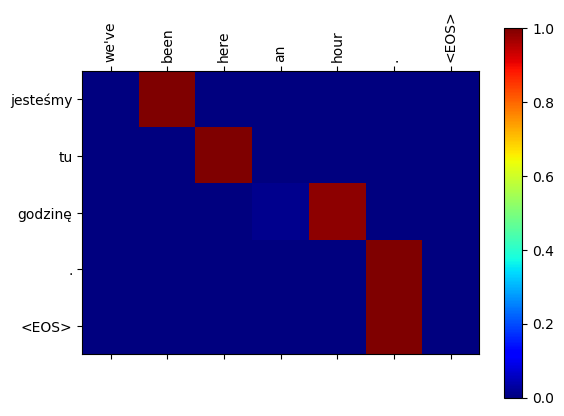

In [41]:
evaluate_and_show_attention("we've been here an hour .", 'jesteśmy tutaj godzinę .')

> i don't like it .
= nie lubię tego .
< nie lubię tego . <EOS>


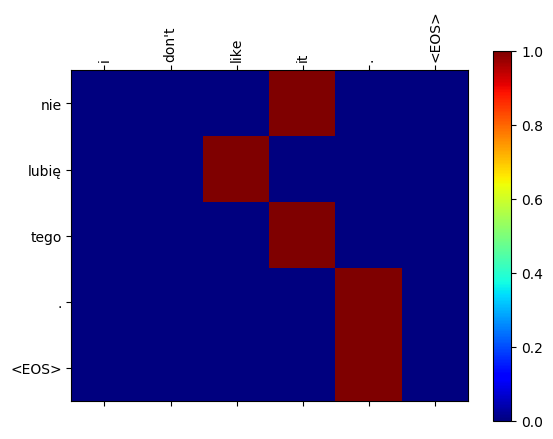

In [42]:
evaluate_and_show_attention("i don't like it .", 'nie lubię tego .')

# Exercises

* Try with a different dataset
    * Another language pair
    * Human &rarr; Machine (e.g. IOT commands)
    * Chat &rarr; Response
    * Question &rarr; Answer
* Replace the embedding pre-trained word embeddings such as word2vec or GloVe
* Try with more layers, more hidden units, and more sentences. Compare the training time and results.
* If you use a translation file where pairs have two of the same phrase (`I am test \t I am test`), you can use this as an autoencoder. Try this:
    * Train as an autoencoder
    * Save only the Encoder network
    * Train a new Decoder for translation from there

# save model

In [ ]:
# what to save?

In [ ]:
# vocab, encoder, decoder, lang1, lang2

In [43]:
encoder.state_dict

<bound method Module.state_dict of EncoderRNN(
  (embedding): Embedding(4972, 500)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
)>

In [44]:
decoder.state_dict

<bound method Module.state_dict of LuongAttnDecoderRNN(
  (embedding): Embedding(9577, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=9577, bias=True)
  (attn): Attn()
)>

In [ ]:
ls -lah data/seq2seq/tmp

In [45]:
from pathlib import Path
import pickle
dataset_path = Path('data/seq2seq')
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [46]:
VOCAB, ENCODER, DECODER = ['vocab', 'encoder', 'decoder']
fn_trn1 = {VOCAB: 'eng-pol.vocab.27450pairs.p', \
           ENCODER: 'batched.encoder.h500.l2.e50000.gpu.torch', \
           DECODER: 'batched.decoder.h500.l2.e50000.gpu.torch'
          }
fn_dict = fn_trn1

In [47]:
import warnings
warnings.filterwarnings('ignore')

torch.save(encoder, tmp_path / fn_dict[ENCODER])
torch.save(decoder, tmp_path / fn_dict[DECODER])

In [48]:
# save vocab

vocab = {'input_lang': input_lang, 'output_lang': output_lang}

pickle.dump(vocab, open(tmp_path / fn_dict[VOCAB], 'wb'))

In [49]:
ls -lah $tmp_path

total 140M
drwxr-xr-x 2 root root 4.0K May  9 06:05 ./
drwxrwxr-x 4 user user 4.0K May  8 18:33 ../
-rw-r--r-- 1 root root  20M May  8 19:41 batched.decoder.h500.l2.e1000.gpu.torch
-rw-r--r-- 1 root root  50M May  9 06:05 batched.decoder.h500.l2.e50000.gpu.torch
-rw-r--r-- 1 root root  32M May  8 19:41 batched.encoder.h500.l2.e1000.gpu.torch
-rw-r--r-- 1 root root  39M May  9 06:05 batched.encoder.h500.l2.e50000.gpu.torch
-rw-r--r-- 1 root root 502K May  9 06:05 eng-pol.vocab.27450pairs.p
-rw-r--r-- 1 root root  91K May  8 19:14 eng-pol.vocab.p
